In [1]:
import pandas as pd
import numpy as np
from time import sleep
from random import uniform
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import seaborn as sns
import matplotlib.pyplot as plt
from selenium.webdriver.chrome.options import Options
import undetected_chromedriver as uc
from bs4 import BeautifulSoup
import re
import asyncio
import nest_asyncio
import aiohttp
from multiprocessing import Pool
import os
import glob
from ast import literal_eval
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import keras_tuner as kt
import joblib
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from tensorflow.keras import regularizers
from scipy.stats import zscore
from sklearn.decomposition import PCA
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from tensorflow.keras import layers, models
import keras_tuner as kt
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow as tf
from scipy.stats import zscore

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
house_types = {
    'Apartment': 'apartment',
    'Flat': 'flat',
    'Condominium': 'condominium',
    'Serviced Residence': 'serviced-residence',
    '1-sty Terrace/Link House': '1-sty-terrace-link-house',
    '2-sty Terrace/Link House': '2-sty-terrace-link-house',
    '3-sty Terrace/Link House': '3-sty-terrace-link-house',
    '4-sty Terrace/Link House': '4-sty-terrace-link-house',
    '1.5-sty Terrace/Link House': '1-5-sty-terrace-link-house',
    '2.5-sty Terrace/Link House': '2-5-sty-terrace-link-house',
    '3.5-sty Terrace/Link House': '3-5-sty-terrace-link-house',
    '4.5-sty Terrace/Link House': '4-5-sty-terrace-link-house',
    'Townhouse': 'townhouse',
    'Cluster House': 'cluster-house',
    'Bungalow': 'bungalow',
    'Semi-detached House': 'semi-detached-house'
}

In [3]:
options = Options()
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")
driver = uc.Chrome(options=options)

for house_type, house_type_url in house_types.items():
    data = []
    existing_records = set()
    max_properties = 1500
    page_number = 0

    while True:
        driver.get(f'https://www.iproperty.com.my/sale/{house_type_url}/?page={page_number}')
        print(f"Scraping {house_type}, Page: {page_number}")

        try:
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, "//div[contains(@class, 'ListingsListstyle__ListingResultPage-iIneXB dBXYzA')]"))
            )
        except Exception:
            print(f"Failed to load data on page {page_number} for {house_type}. Ending scrape for this house type.")
            page_number += 1
            continue

        houses = driver.find_elements(By.XPATH, "//li[contains(@class, 'ListingsListstyle__ListingListItemWrapper-hjHtwj')]")
        print(f"Found {len(houses)} houses on page {page_number}")

        for house in houses:
            try:
                # Skip if it's a false house
                try:
                    false_house = house.find_element(By.XPATH, ".//li[contains(@class, 'ListingPricestyle__RangePriceWrapper')]")
                    if false_house:
                        continue
                except:
                    pass

                # Title
                try:
                    title = house.find_element(By.XPATH, ".//h2[contains(@class, 'TitleWrapper')]").text
                except:
                    continue
            
                # Price
                try:
                    price_text = house.find_element(By.XPATH, ".//li[contains(@class, 'ListingPricestyle__ItemWrapper')]").text
                    price = re.sub(r"[^\d]", "", price_text)
                except:
                    continue
            
                # Price per square foot
                try:
                    price_per_sqft_text = house.find_element(By.XPATH, ".//div[contains(@class, 'PricePSFWrapper')]").text
                    price_per_sqft_match = re.search(r"\d+(\.\d+)?", price_per_sqft_text)
                    price_per_sqft = float(price_per_sqft_match.group()) if price_per_sqft_match else None
                except:
                    continue

                # Size
                try:
                    details_text = house.find_element(By.XPATH, ".//div[contains(@class, 'ListingAttributesstyle__ListingAttrsDescriptionWrapper')]").text
                    built_up_match = re.search(r"Built-up\s*:\s*([\d,]+)\s*sq\. ft\.", details_text)
                    size = int(built_up_match.group(1).replace(",", "")) if built_up_match else None
                except:
                    continue
            
                # District, State
                try:
                    location = house.find_element(By.XPATH, ".//div[contains(@class, 'AddressWrapper')]").text
                    district = location.split(",")[0].title()
                    state = location.split(",")[1].title()
                except:
                    continue
            
                # Facilities: Bedrooms, Bathrooms, Car Slots
                try:
                    bed_number_text = house.find_element(By.XPATH, ".//li[contains(@class, 'bedroom-facility')]").text
                    bed_number = sum(int(num.strip()) for num in bed_number_text.split("+")) if "+" in bed_number_text else int(re.sub(r"[^\d]", "", bed_number_text))
                except:
                    bed_number = None
            
                try:
                    bath_number_text = house.find_element(By.XPATH, ".//li[contains(@class, 'bathroom-facility')]").text
                    bath_number = sum(int(num.strip()) for num in bath_number_text.split("+")) if "+" in bath_number_text else int(re.sub(r"[^\d]", "", bath_number_text))
                except:
                    bath_number = None
            
                try:
                    car_number_text = house.find_element(By.XPATH, ".//li[contains(@class, 'carPark-facility')]").text
                    car_number = sum(int(num.strip()) for num in car_number_text.split("+")) if "+" in car_number_text else int(re.sub(r"[^\d]", "", car_number_text))
                except:
                    car_number = None

                try:
                    link = house.find_elements(By.XPATH, ".//a[@class='depth-listing-card-link']")[0].get_attribute('href')
                    driver.get(link)
                    WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.TAG_NAME, "main"))
                    )

                    # Location
                    try:
                        location = driver.find_element(By.XPATH, ".//h3[@class='sc-7f8bc4dc-3 bIEBdJ']").text
                        location = location.lstrip('-').strip()
                    except:
                        location = None

                    property_types = driver.find_elements(By.XPATH, ".//div[@class='sc-7f5a3941-3 hppKud']")

                    # Furnished Type
                    furnished_type = "Unfurnished"
                    try:
                        for property_type in property_types:
                            key = property_type.find_element(By.XPATH, ".//div[@class='sc-7f5a3941-4 fRSLqG']").text.strip()
                            if key == "Furnishing":
                                furnished_type = property_type.find_element(By.XPATH, ".//div[@class='sc-7f5a3941-5 dBVzEl']").text.title()
                                break
                    except:
                        pass

                    # Tenure
                    tenure = "Freehold"
                    try:
                        for property_type in property_types:
                            key = property_type.find_element(By.XPATH, ".//div[@class='sc-7f5a3941-4 fRSLqG']").text.strip()
                            if key == "Tenure":
                                tenure = property_type.find_element(By.XPATH, ".//div[@class='sc-7f5a3941-5 dBVzEl']").text.title()
                                break
                    except:
                        pass

                    # Facilities
                    try:
                        facilities = [
                            facility.get_attribute("textContent").strip().title()
                            for facility in driver.find_elements(By.XPATH, './/div[@class="sc-e3513120-3 UvxtV"]')
                        ]
                    except:
                        facilities = None

                    # Images
                    try:
                        img_urls = set()
                        modal_button = WebDriverWait(driver, 10).until(
                            EC.element_to_be_clickable((By.XPATH, '//div[contains(@class, "sc-649895dc-2 EjzXT")]'))
                        )
                        modal_button.click()
                        WebDriverWait(driver, 10).until(
                            EC.presence_of_element_located((By.XPATH, '//div[contains(@class, "sc-58485778-3 kFvCff")]//img'))
                        )
                    
                        images = driver.find_elements(By.XPATH, '//div[contains(@class, "sc-58485778-3 kFvCff")]//img')
                        for img in images:
                            src = img.get_attribute('src')
                            if src:
                                img_urls.add(src)
                                
                        close_button = driver.find_element(By.XPATH, '//div[contains(@class, "sc-5954de88-3 hWffUk")]')
                        close_button.click()
                    except Exception as e:
                        # print(f"Error extracting images: {e}")
                        img_urls = []

                except:
                    continue

                finally:
                    driver.back()

                record = (
                    title, price, district, state, bed_number, location, furnished_type, size, bath_number, car_number, house_type, price_per_sqft, tuple(img_urls)
                )

                if record in existing_records:
                    continue

                existing_records.add(record)
                    
                data.append({
                    "Title": title,
                    "Price": price,
                    "District": district,
                    "State": state,
                    "Bedrooms": bed_number,
                    "Location": location,
                    "Tenure": tenure,
                    "Furnished Type": furnished_type,
                    "Size": size,
                    "Facilities": facilities,
                    "Bathrooms": bath_number,
                    "Car Slots": car_number,
                    "House Type": house_type,
                    "Price per sqft": price_per_sqft,
                    "Images": img_urls,
                })
            except Exception as e:
                print(f"Error extracting house details: {e}")

        if len(data) >= max_properties:
            print(f"Reached max properties limit ({max_properties}) for {house_type}. Ending scrape.")
            break

        try:
            next_page_button = driver.find_element(By.XPATH, "//a[@aria-label='Go to next page']")
            if next_page_button:
                page_number += 1
                print(len(data))
        except Exception:
            print(f"No 'next page' button found on page {page_number}. Ending scrape for {house_type}.")
            break

    output_directory = "data"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    file_name = f"{output_directory}/property-{house_type_url}.csv"
    df = pd.DataFrame(data[:max_properties])
    df.to_csv(file_name, index=False, encoding="utf-8")
    print(f"Data saved to {file_name}")

driver.quit()

In [4]:
folder_path = 'data'
all_files = []
for house_type in house_types.values():
    pattern = os.path.join(folder_path, f'property-{house_type}.csv')
    all_files.extend(glob.glob(pattern))

combined_df = pd.concat([pd.read_csv(file) for file in all_files], ignore_index=True)
combined_file_path = 'data/combined_property_data.csv'
combined_df.to_csv(combined_file_path, index=False)

In [5]:
df = combined_df
df.head()

Title   Price       District  \
0  Austin Regency (Pangsapuri Austin Perdana), Ta...  680000         Tebrau   
1                   Pangsapuri Seri Baiduri, Perling  218000        Perling   
2                         Sri Intan 1, Jalan Kuching  258000  Jalan Kuching   
3                       Mentari Court, Petaling Jaya  290000  Petaling Jaya   
4  Bistari Impian Apartment, Taman Dato Onn, Joho...  350000    Johor Bahru   

           State  Bedrooms                                           Location  \
0          Johor       4.0  Jalan Austin Perdana Utama, Taman Austin Perda...   
1          Johor       3.0                      Jalan Baiduri 3, 80100, Johor   
2   Kuala Lumpur       3.0           No.2 Jalan Trolak 6, 51200, Kuala Lumpur   
3       Selangor       3.0                      Jalan PJS8/9, 46150, Selangor   
4          Johor       3.0     0 Jalan Serantau, Taman Dato Onn, 80350, Johor   

      Tenure    Furnished Type    Size  \
0   Freehold   Fully Furnished  1317.0   
1   Freehold       Unfurnished   750.0   
2   Freehold  Partly Furnished   905.0   
3  Leasehold  Partly Furnished   775.0   
4  Leasehold       Unfurnished  1078.0   

                                          Facilities  Bathrooms  Car Slots  \
0  ['Kitchen Cabinet', 'Air Conditioner', 'Balcon...        3.0        2.0   
1                                                 []        2.0        1.0   
2  ['Kitchen Cabinet', 'Air Conditioner', 'Parkin...        2.0        1.0   
3  ['Bbq', 'Jogging Track', 'Playground', 'Gym', ...        2.0        1.0   
4  ['Balcony', 'Bbq', 'Jogging Track', 'Playgroun...        2.0        NaN   

  House Type  Price per sqft  \
0  Apartment          516.32   
1  Apartment          290.67   
2  Apartment          285.08   
3  Apartment          374.19   
4  Apartment          324.68   

                                              Images  
0  {'https://img.iproperty.com.my/my-iproperty/pr...  
1  {'https://img.iproperty.com.my/my-iproperty/pr...  
2  {'https://img.iproperty.com.my/my-iproperty/pr...  
3  {'https://img.iproperty.com.my/my-iproperty/pr...  
4  {'https://img.iproperty.com.my/my-iproperty/pr...

In [6]:
len(df)

19462

In [7]:
df = df.drop_duplicates(subset=df.columns.difference(['Facilities']))

In [8]:
print(len(df))

19462


In [9]:
# Identify missing values in critical columns
critical_columns = ['Price', 'Size', 'Bedrooms', 'Bathrooms', 'Car Slots', 'District', 'State', 'Price per sqft', 'Furnished Type', 'House Type', 'Facilities', ]
missing_summary_critical = df[critical_columns].isnull().sum()
missing_summary_critical

Price                0
Size               113
Bedrooms           153
Bathrooms           56
Car Slots         6319
District             0
State                0
Price per sqft       8
Furnished Type       0
House Type           0
Facilities           0
dtype: int64

In [10]:
# Drop rows with missing critical values
df = df.dropna(subset=['Price', 'Size', 'Bedrooms', 'Bathrooms', 'Price per sqft'], how='any')

# Drop Unnecessary Columns
columns_to_drop = ['Location', 'Title', 'Images']
df = df.drop(columns=columns_to_drop, errors='ignore')

In [11]:
# Impute missing numerical values
numerical_critical = ['Bedrooms', 'Bathrooms', 'Car Slots']
df[numerical_critical] = df[numerical_critical].fillna(df[numerical_critical].median())

In [12]:
# Address Outliers for Numerical Data
numerical_columns = ['Price', 'Size', 'Price per sqft']
for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [13]:
# Fix Inconsistent Formatting
categorical_columns = ['State', 'Tenure', 'Furnished Type', 'House Type', 'District']
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.str.strip().str.lower())

In [14]:
df.columns

Index(['Price', 'District', 'State', 'Bedrooms', 'Tenure', 'Furnished Type',
       'Size', 'Facilities', 'Bathrooms', 'Car Slots', 'House Type',
       'Price per sqft'],
      dtype='object')

In [15]:
# Create Derived Features
df['Price per Bedroom'] = df['Price'] / df['Bedrooms']
df['Room Density'] = df['Bedrooms'] / df['Size']

In [16]:
df.to_csv('data/cleaned_combined_property_data.csv')

In [17]:
# Generate and interpret summary statistics and Validate Data Quality
summary_statistics = df.describe()
summary_statistics

Price      Bedrooms          Size     Bathrooms     Car Slots  \
count  1.625100e+04  16251.000000  16251.000000  16251.000000  16251.000000   
mean   9.627161e+05      4.072672   2090.864439      3.255184      2.193219   
std    6.936631e+05      1.304835   1142.383706      1.465852      0.976628   
min    1.548800e+04      1.000000    140.000000      1.000000      1.000000   
25%    4.200000e+05      3.000000   1100.000000      2.000000      2.000000   
50%    7.680000e+05      4.000000   1900.000000      3.000000      2.000000   
75%    1.350000e+06      5.000000   2900.000000      4.000000      2.000000   
max    3.478000e+06     19.000000   5523.000000     15.000000     12.000000   

       Price per sqft  Price per Bedroom  Room Density  
count    16251.000000       1.625100e+04  16251.000000  
mean       442.764500       2.236546e+05      0.002333  
std        173.587615       1.314162e+05      0.000918  
min          4.160000       3.097600e+03      0.000194  
25%        314.875000       1.266667e+05      0.001667  
50%        414.140000       1.980000e+05      0.002088  
75%        542.045000       2.900000e+05      0.002857  
max        965.000000       2.750000e+06      0.012121

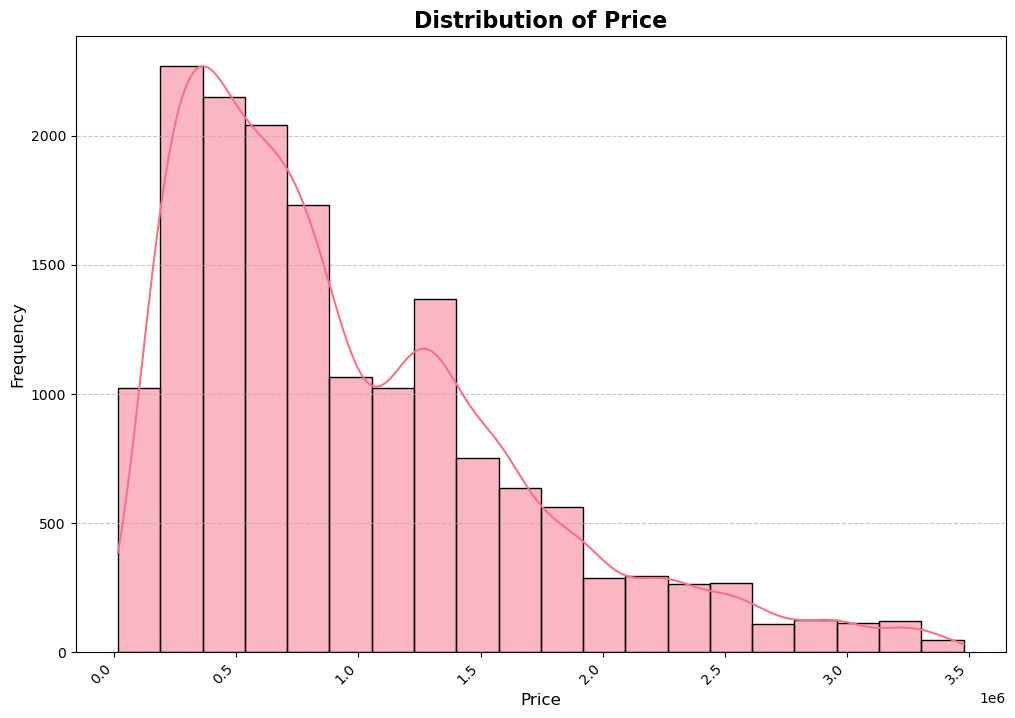

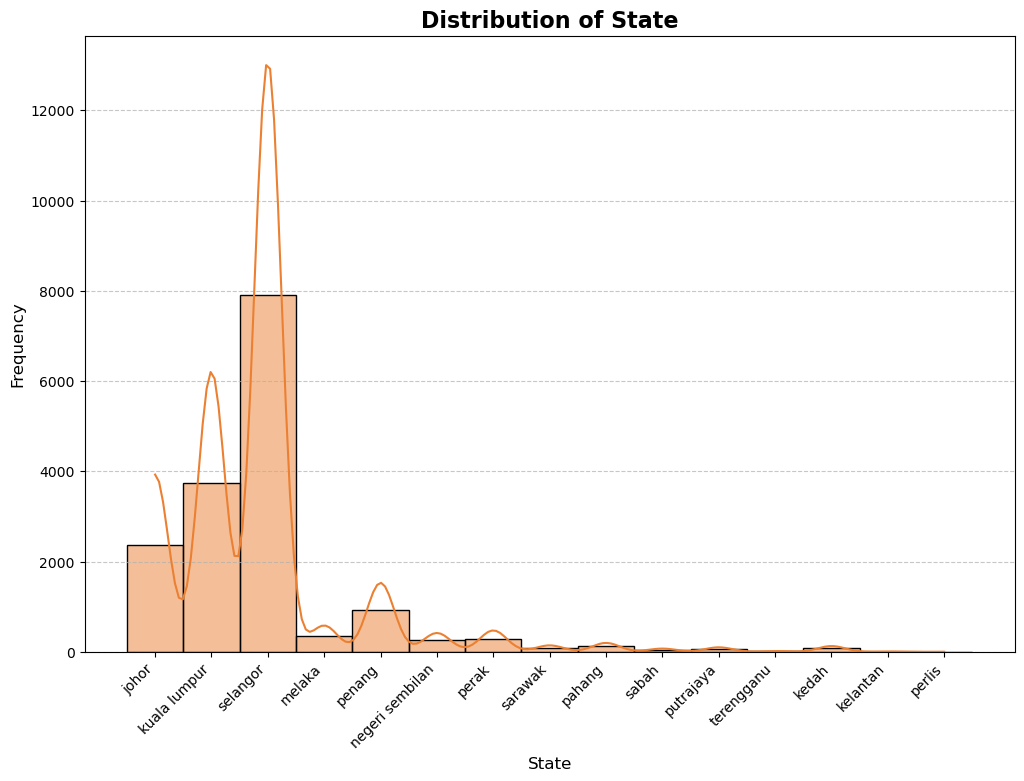

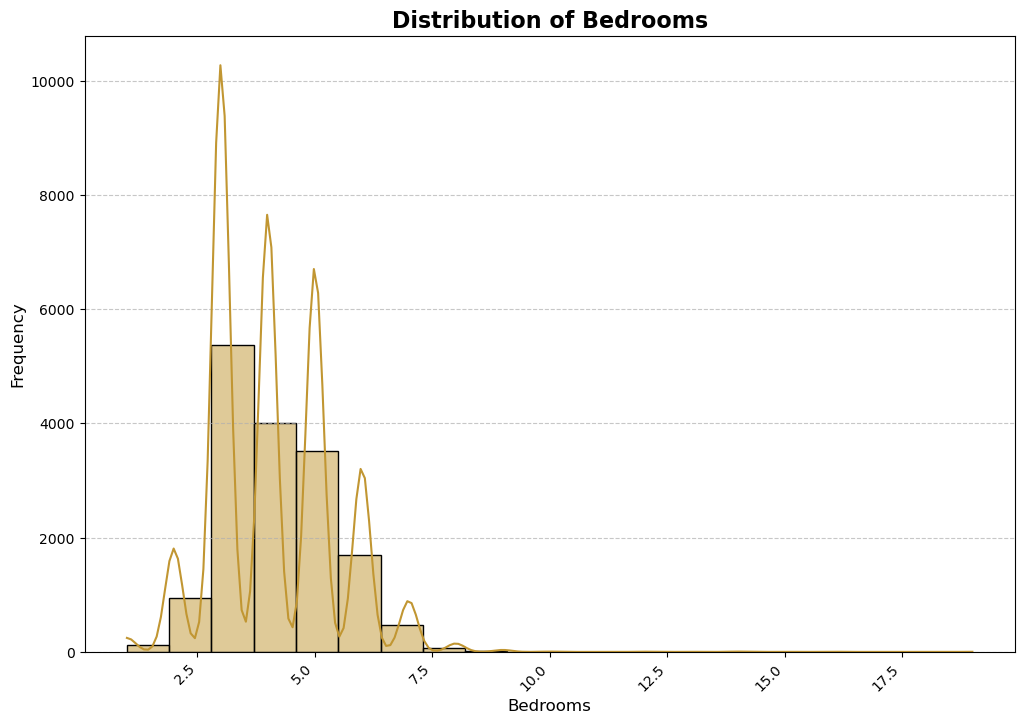

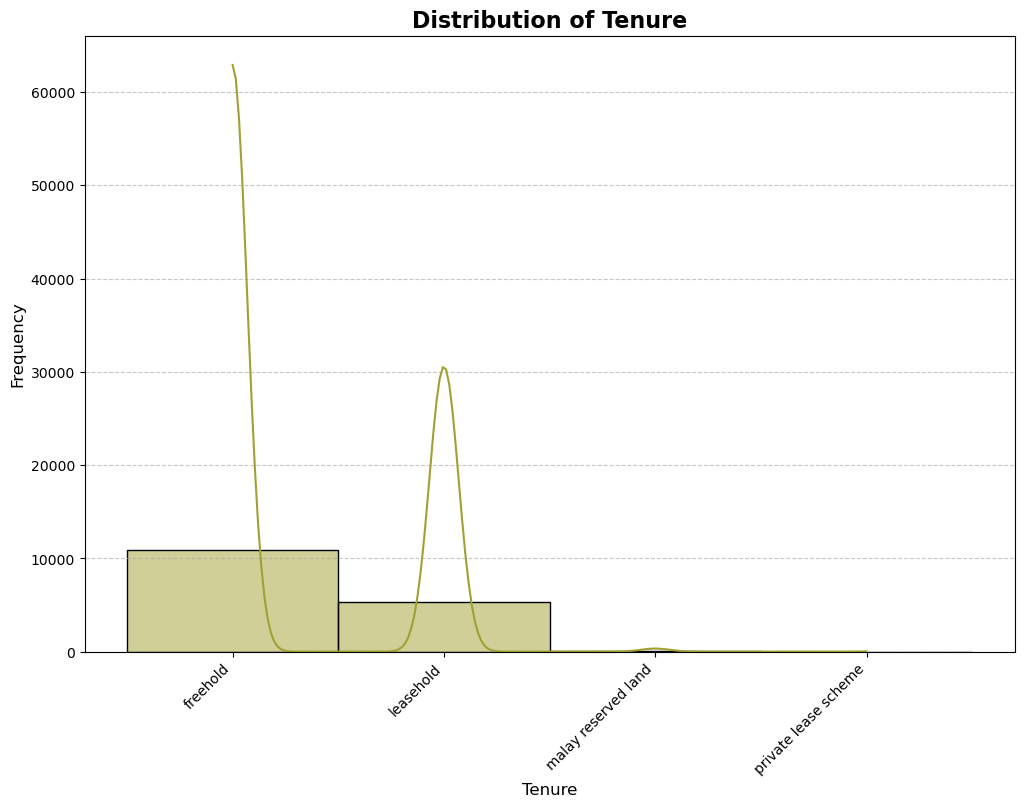

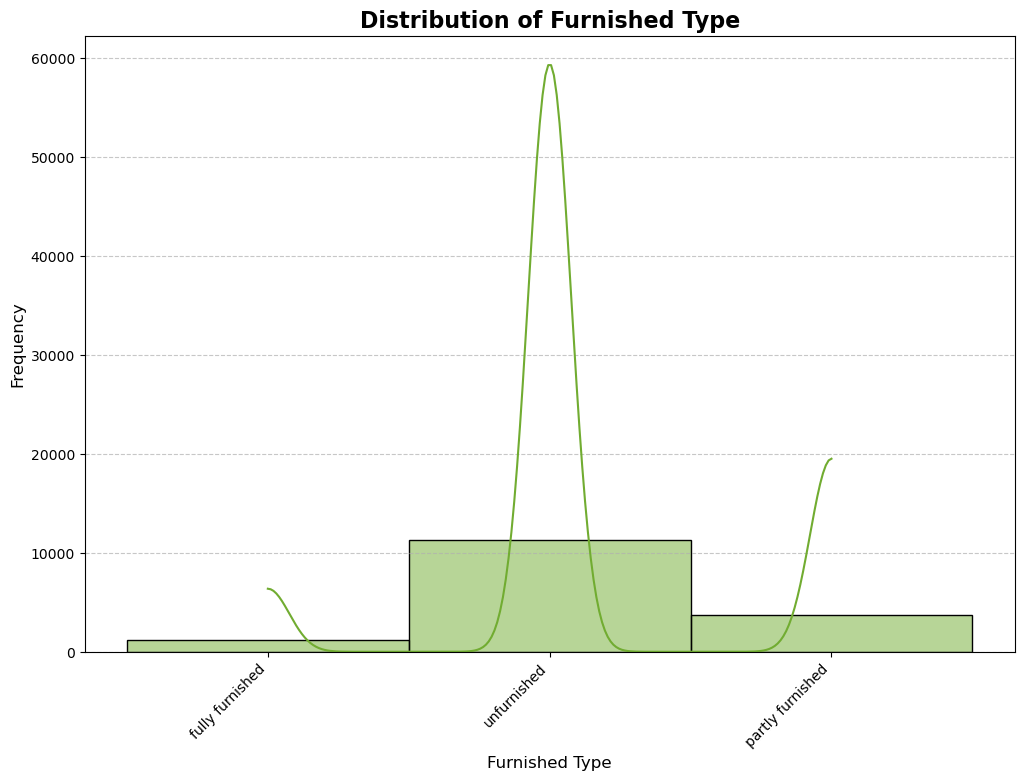

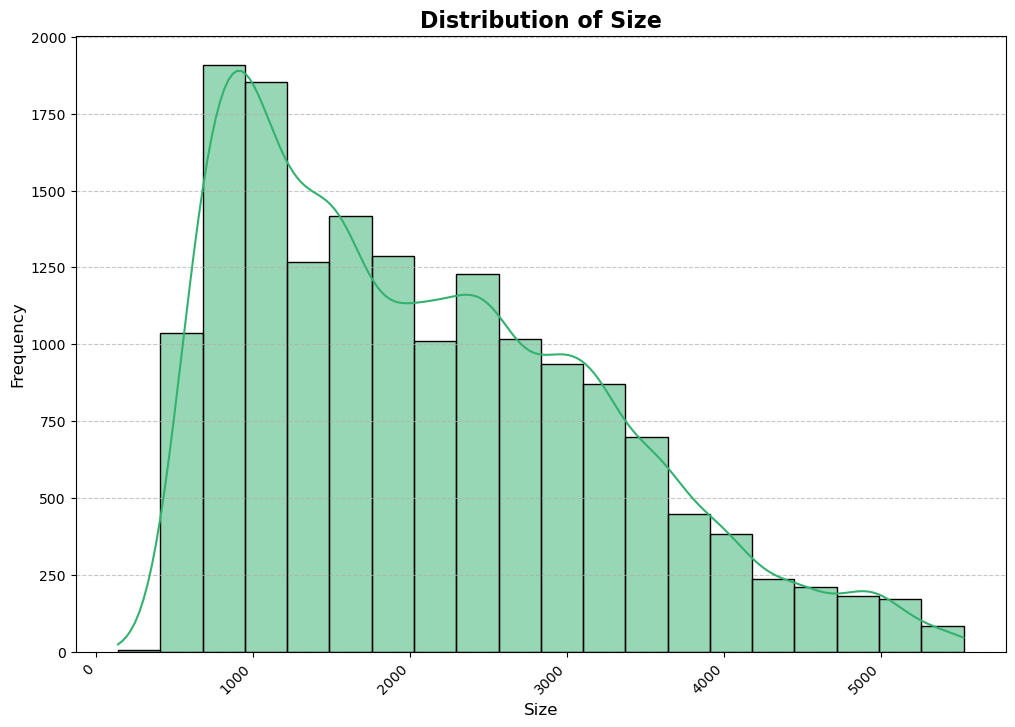

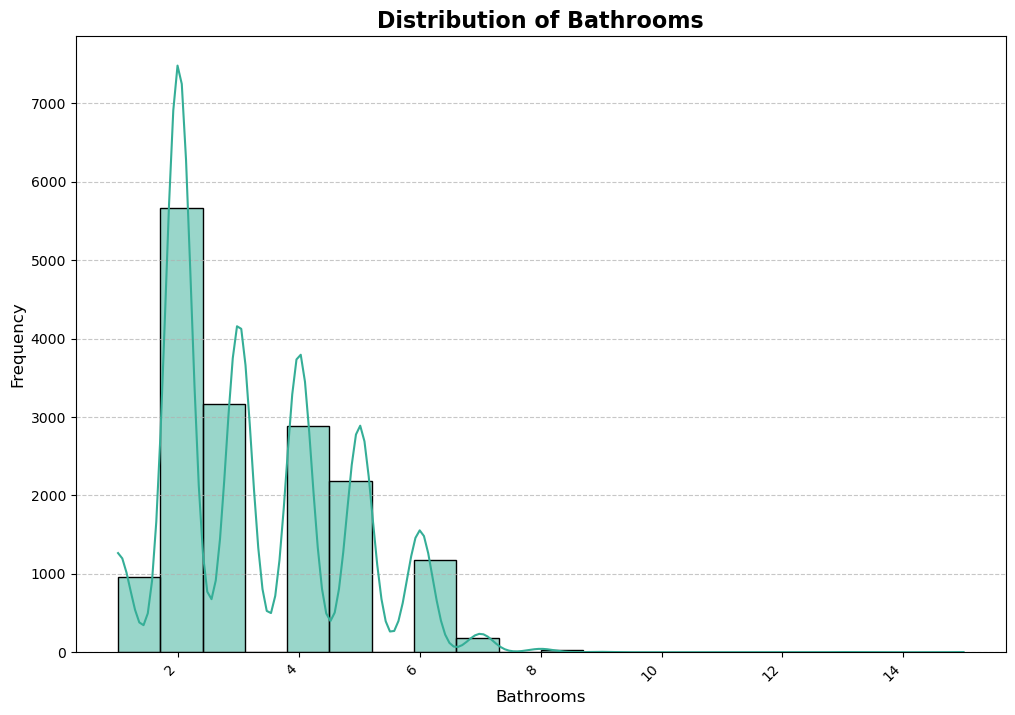

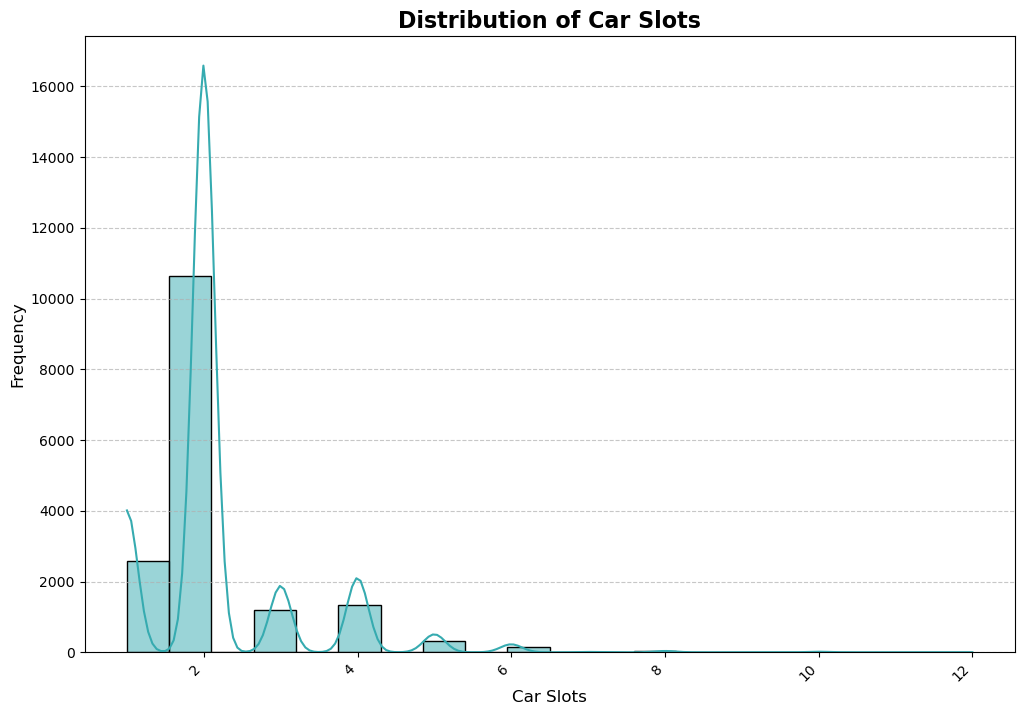

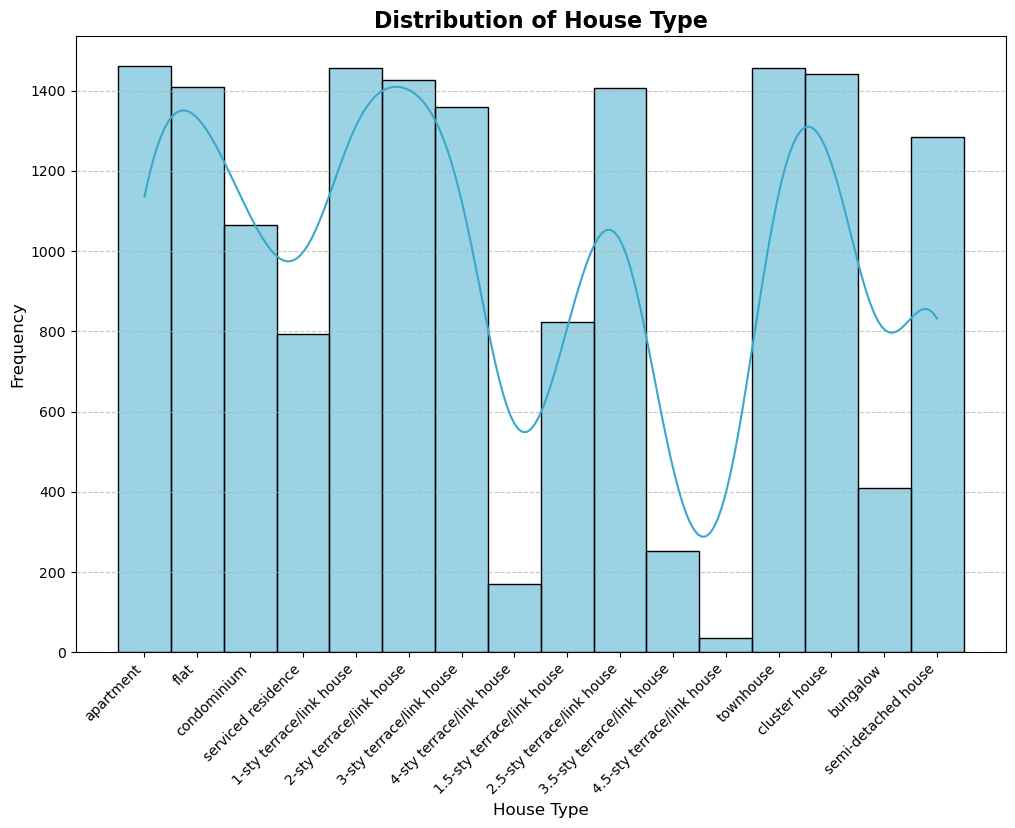

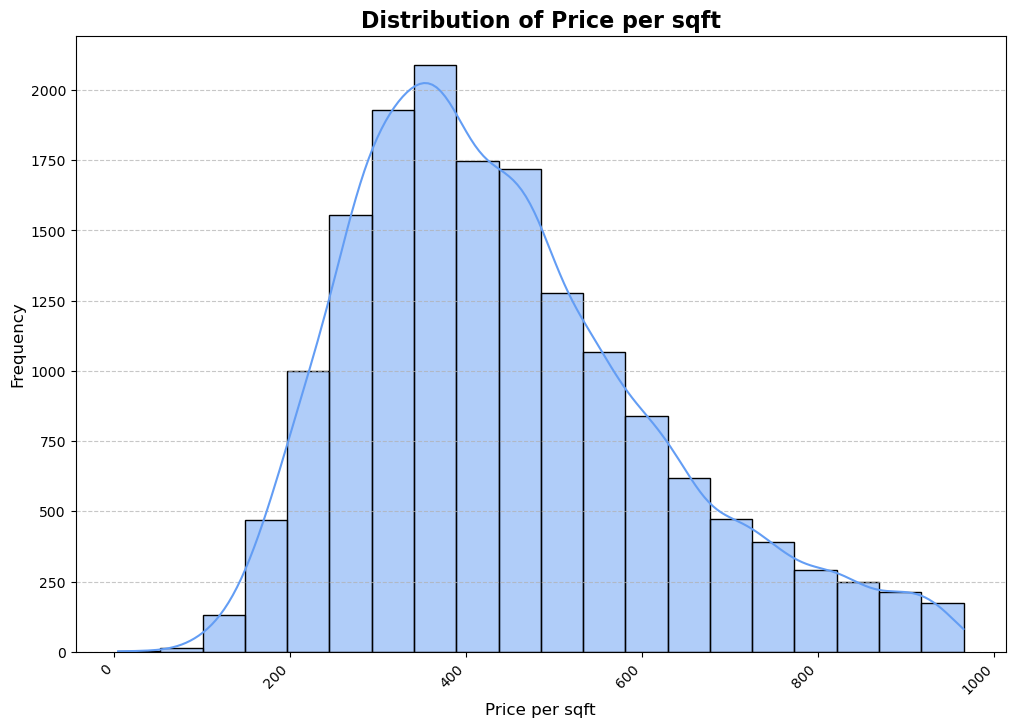

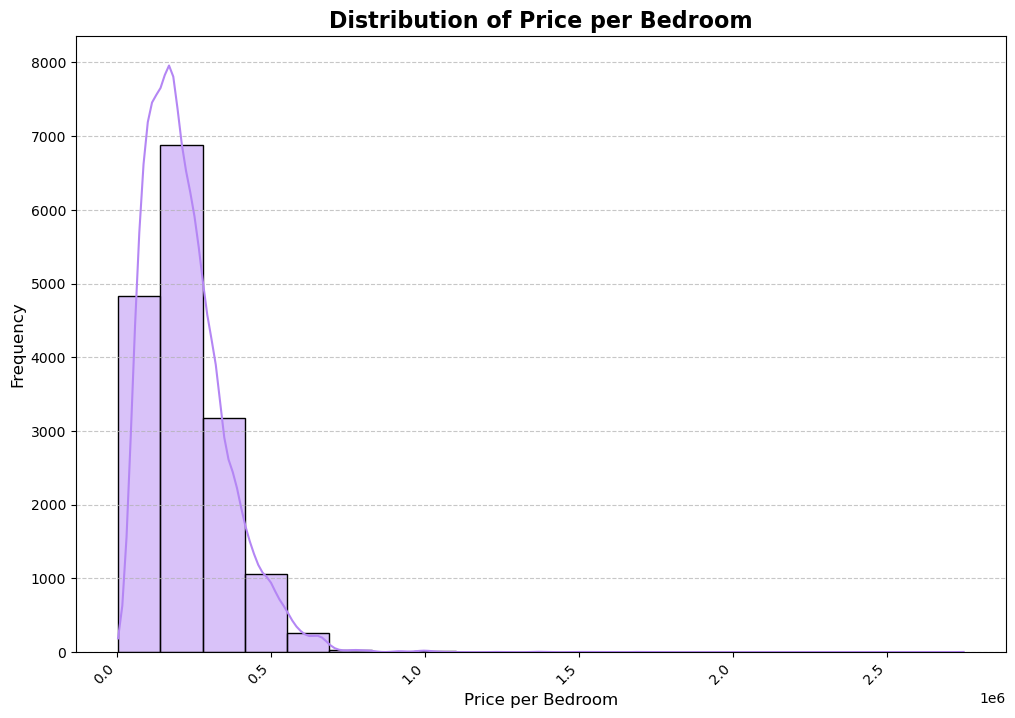

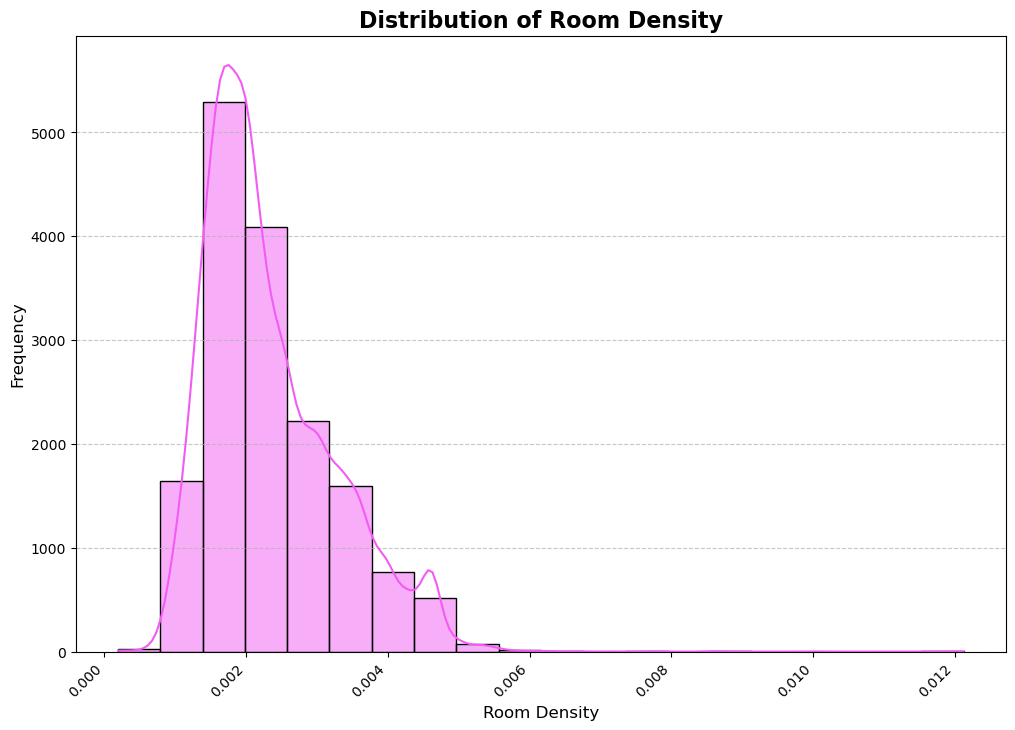

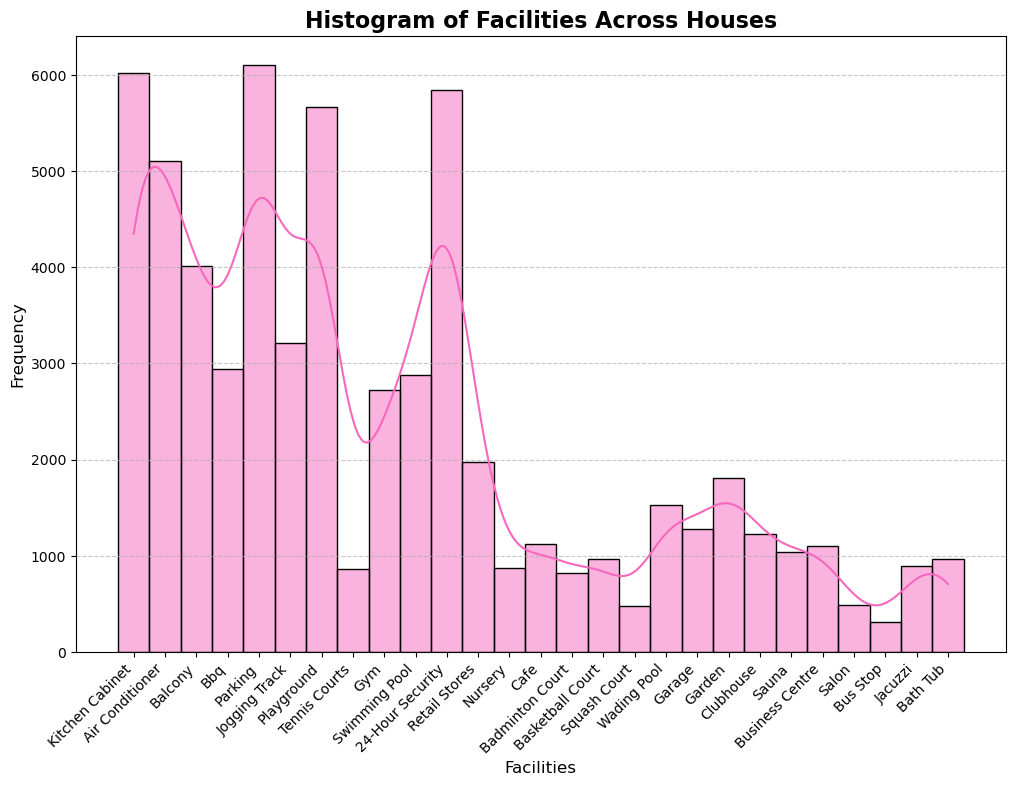

In [18]:
# Analyze data distributions for key variables
columns_to_plot = [
    col for col in df.columns
    if col not in ['Facilities', 'State_code', 'Tenure_code', 'Furnished Type_code', 'Facilities_code', 'House Type_code', 'District']
]

colors = sns.color_palette("husl", n_colors=len(columns_to_plot) + 1)

for idx, column in enumerate(columns_to_plot):
    plt.figure(figsize=(12, 8))
    sns.histplot(data=df, x=column, bins=20, kde=True, color=colors[idx], edgecolor="black")
    plt.title(f'Distribution of {column}', fontsize=16, fontweight='bold')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

df['Facilities_list'] = df['Facilities'].apply(lambda x: eval(x) if isinstance(x, str) else [])
all_facilities = [facility for sublist in df['Facilities_list'] for facility in sublist]
facility_expanded_df = pd.DataFrame({'Facility': all_facilities})


plt.figure(figsize=(12, 8))
sns.histplot(data=facility_expanded_df, x='Facility', kde=True, bins=20, color=colors[-1], edgecolor="black")
plt.title('Histogram of Facilities Across Houses', fontsize=16, fontweight='bold')
plt.xlabel('Facilities', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Text(0.5, 1.0, 'Correlation Matrix')

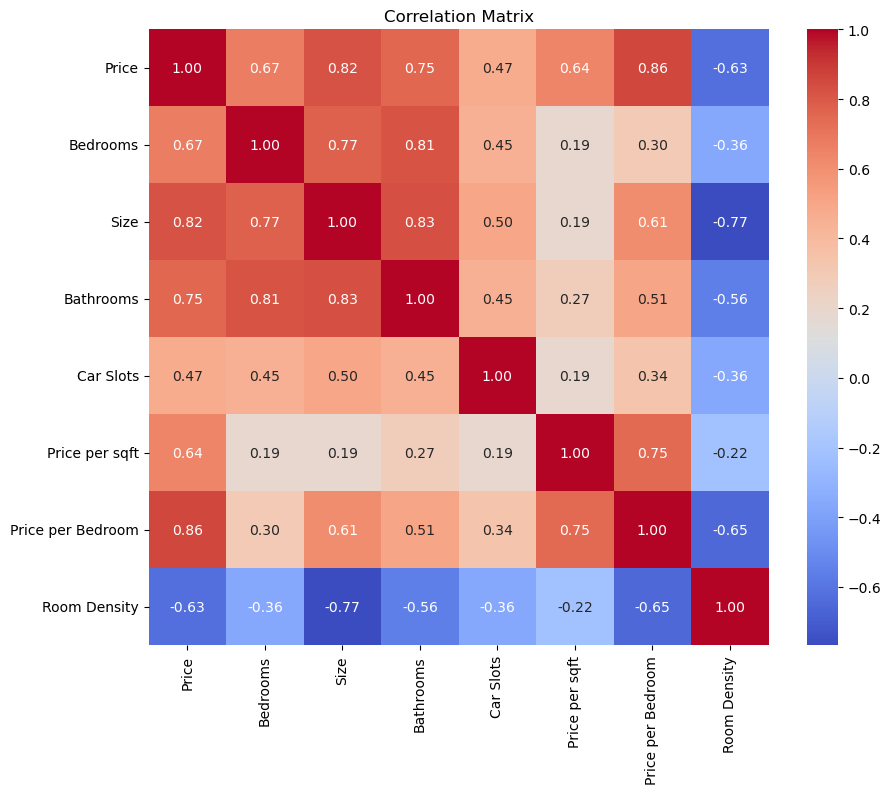

In [19]:
# Create correlation analysis
numerical_df = df.select_dtypes(include=['number']).drop(columns=['Facilities_code'], errors='ignore')
correlation_matrix = numerical_df.corr()
fig3, ax3 = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=ax3)
ax3.set_title('Correlation Matrix')

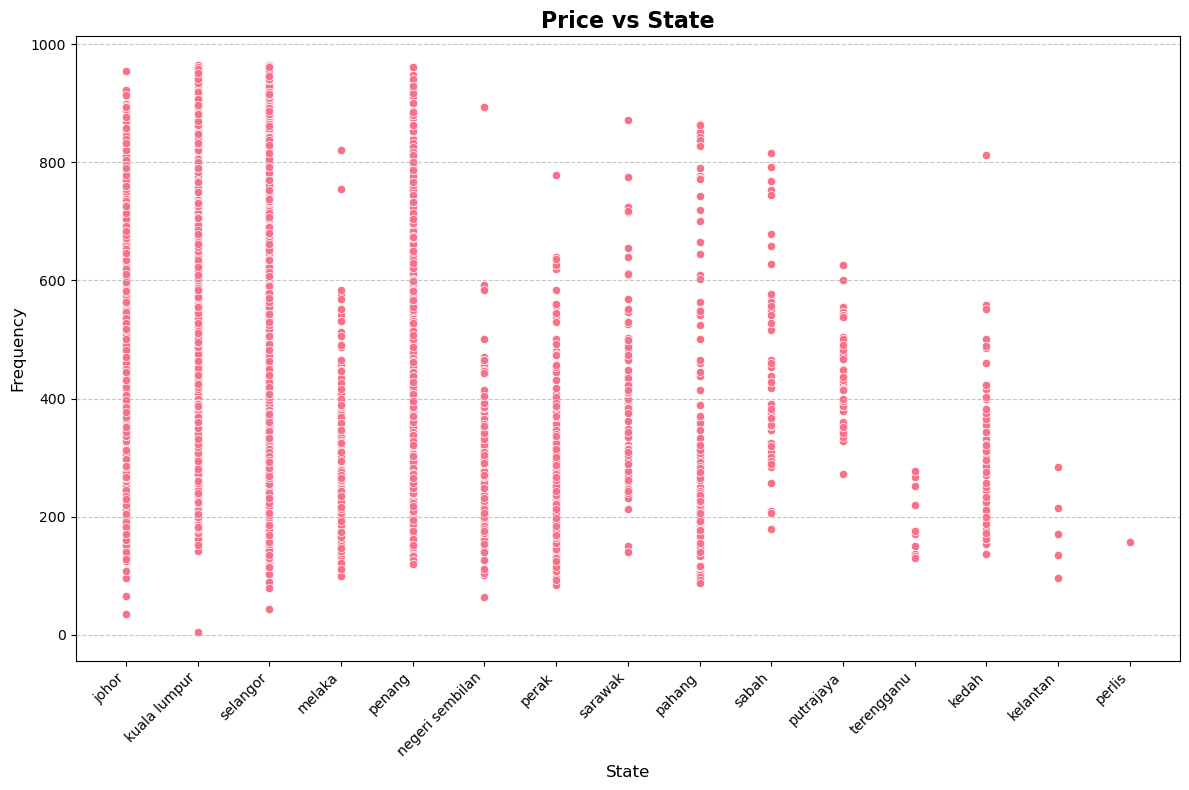

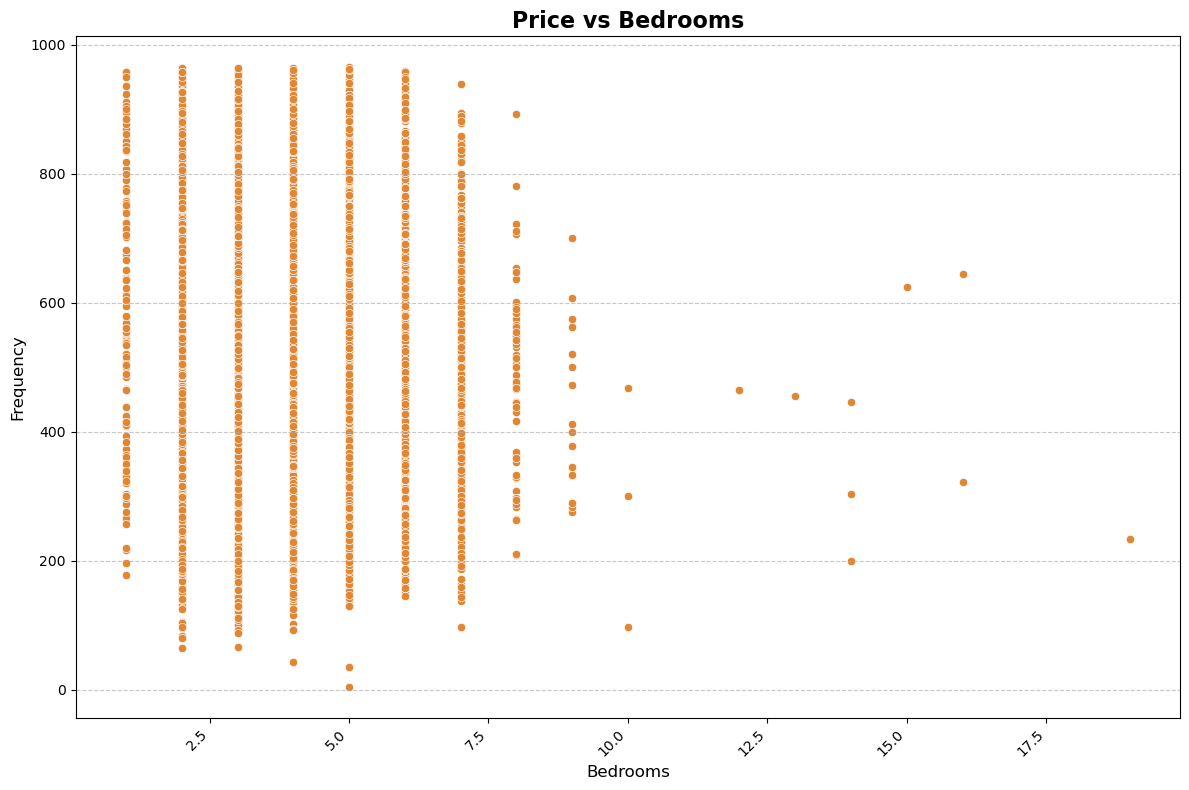

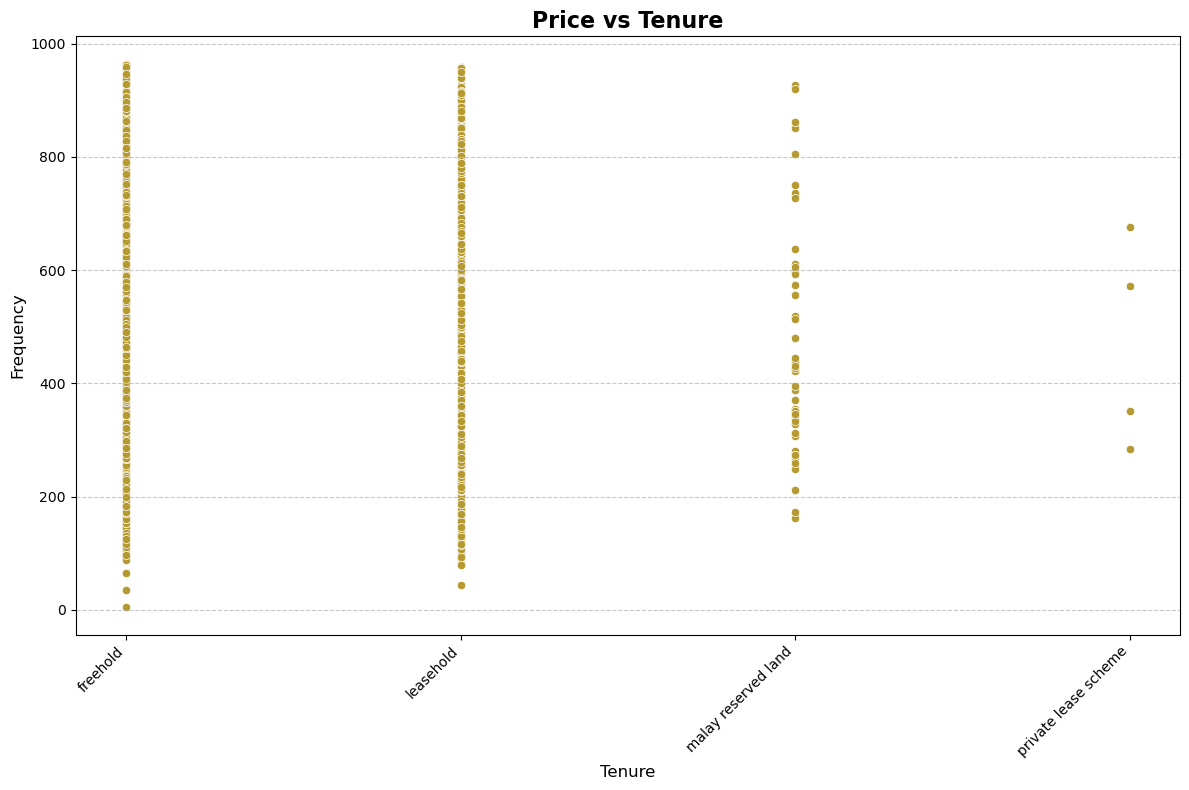

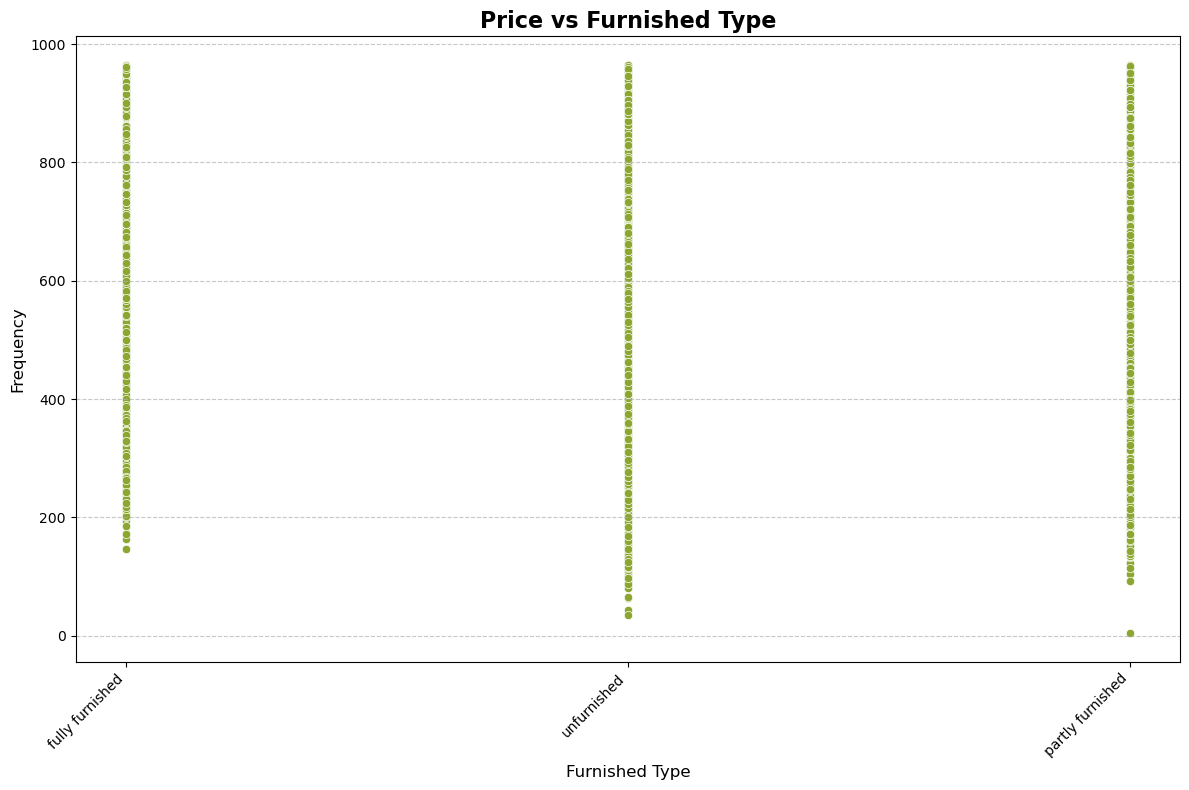

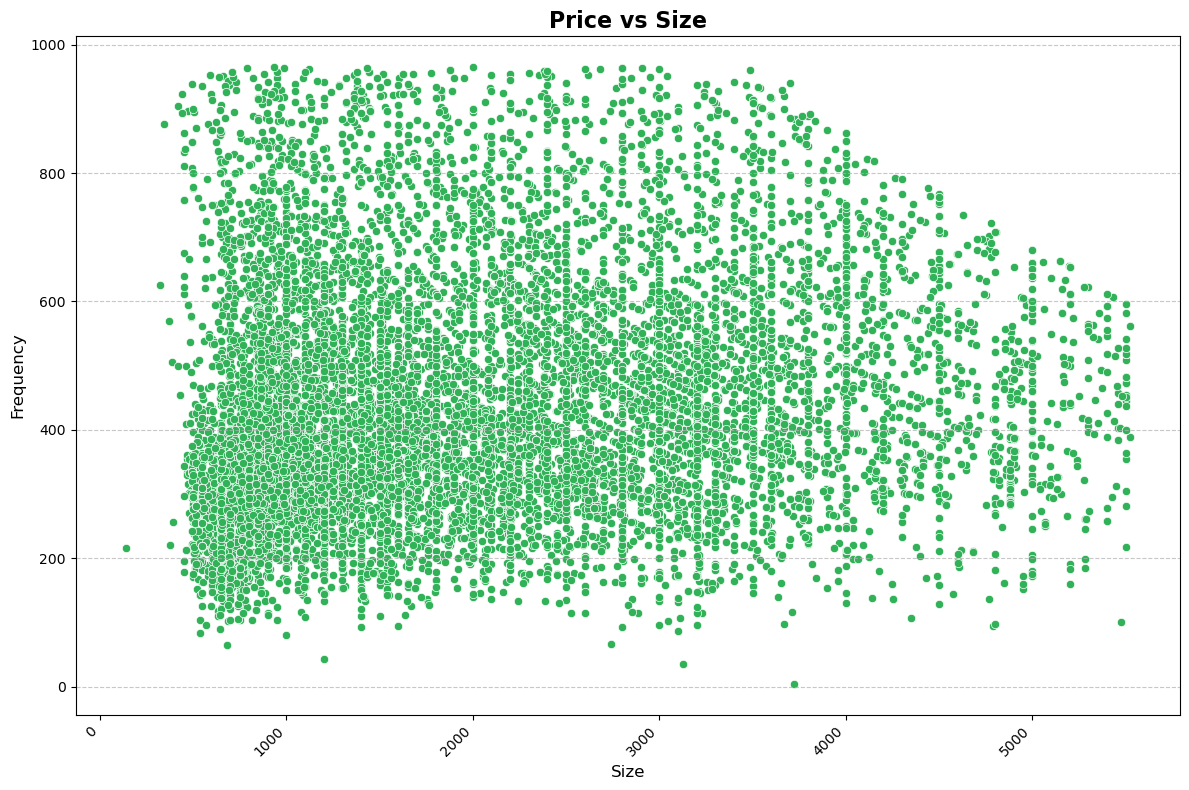

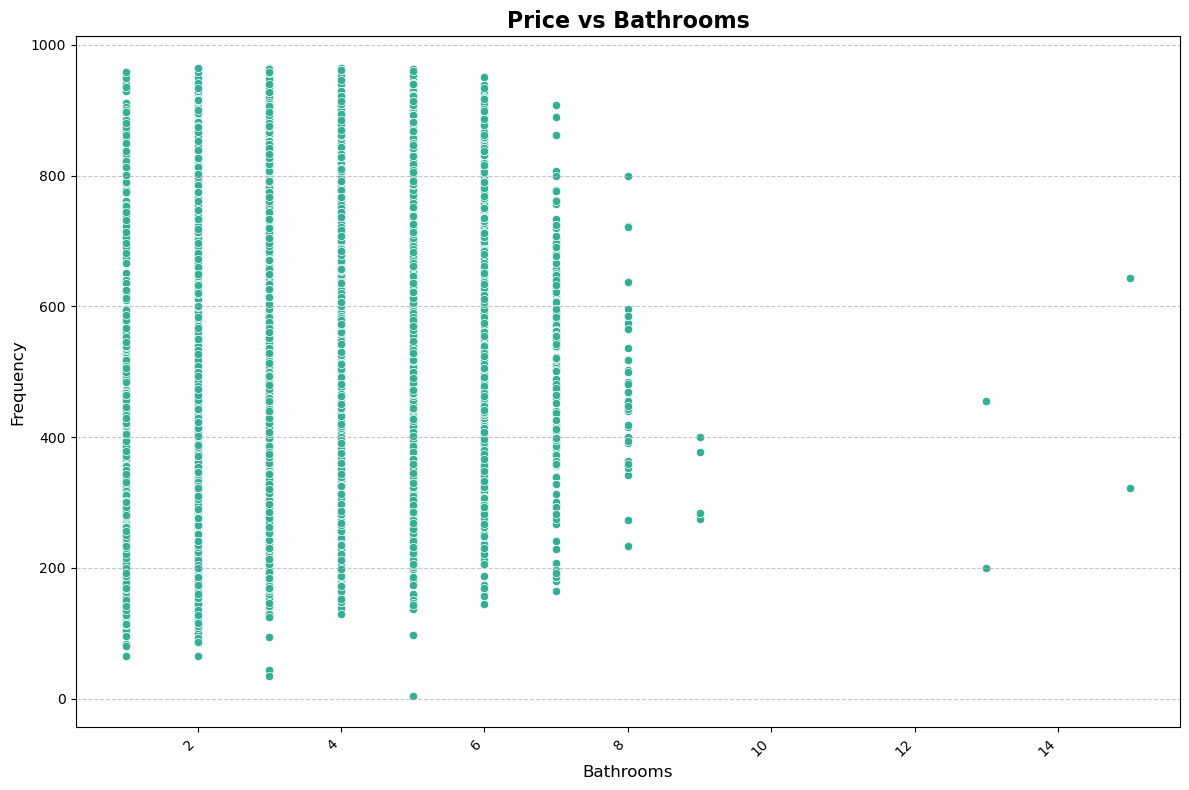

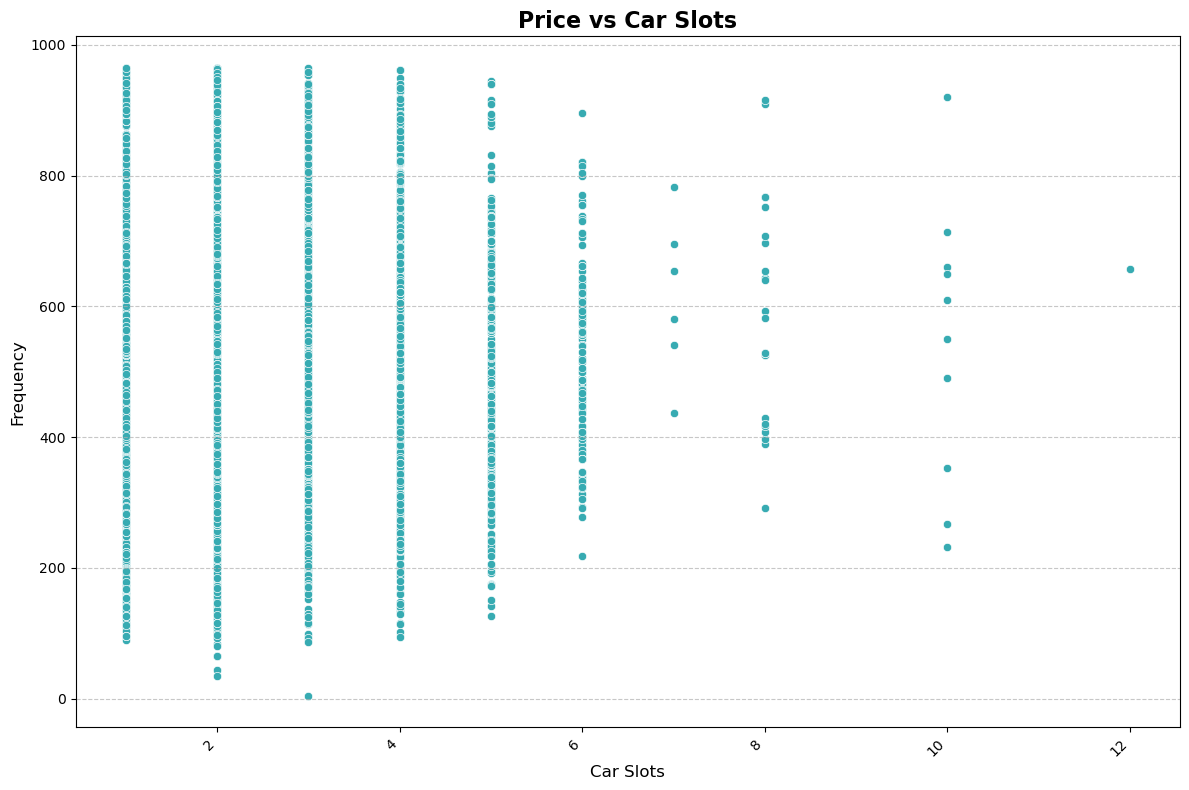

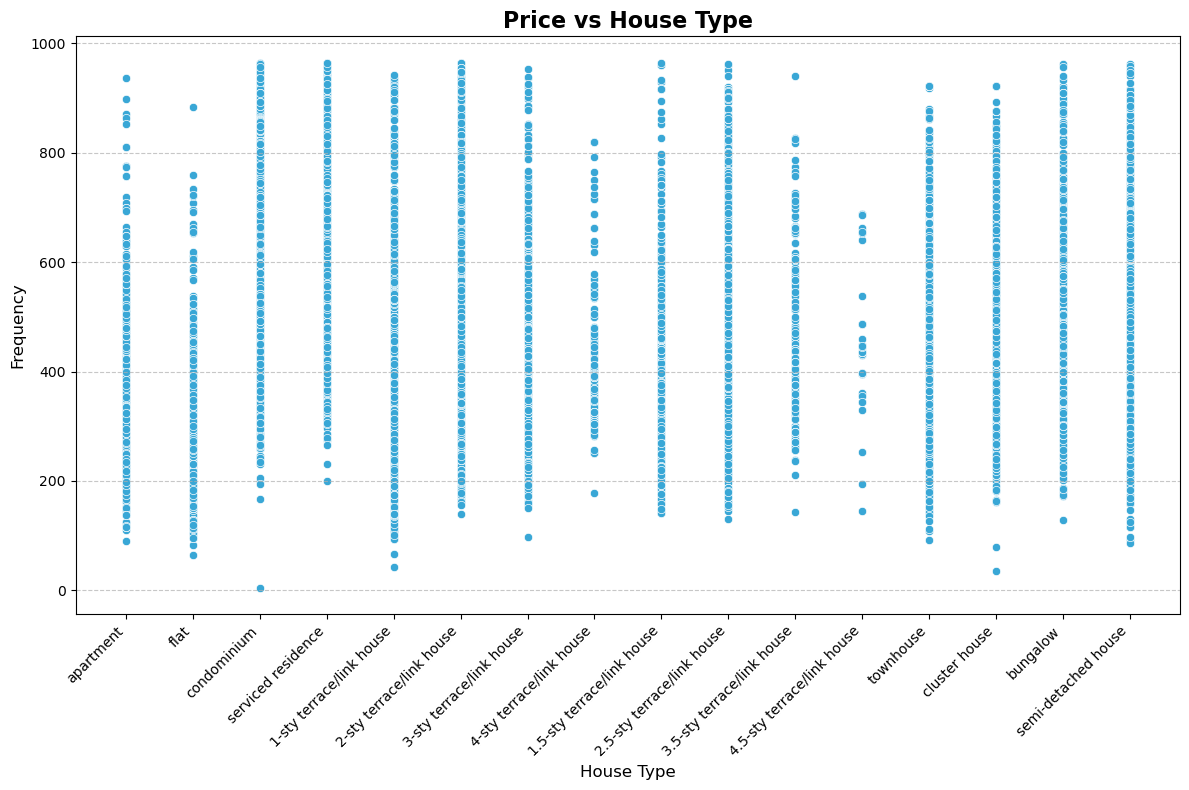

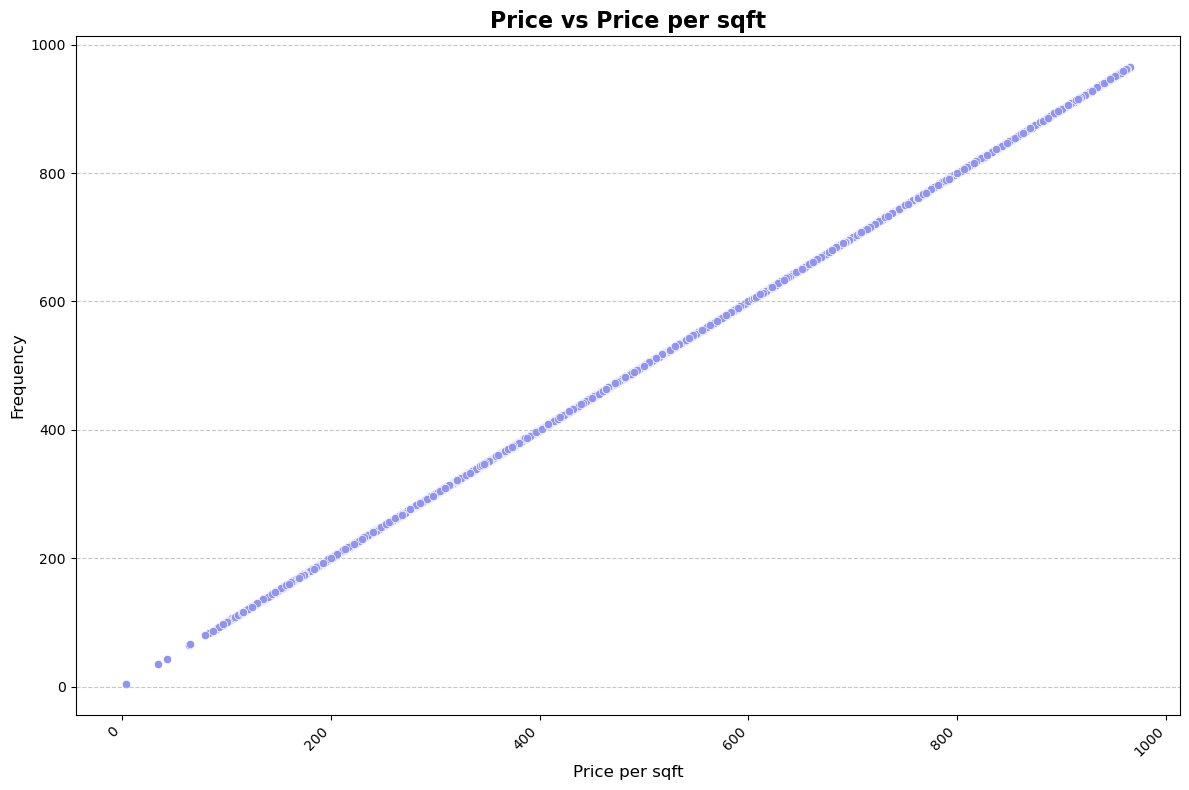

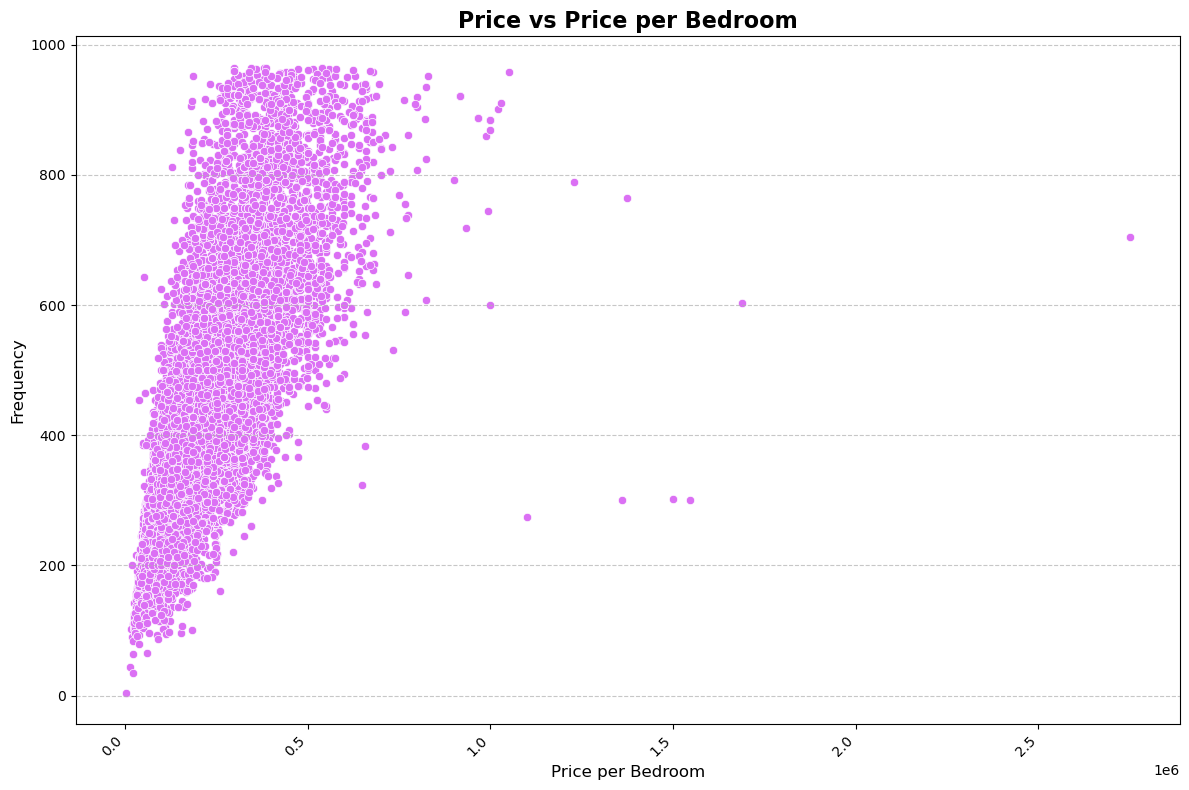

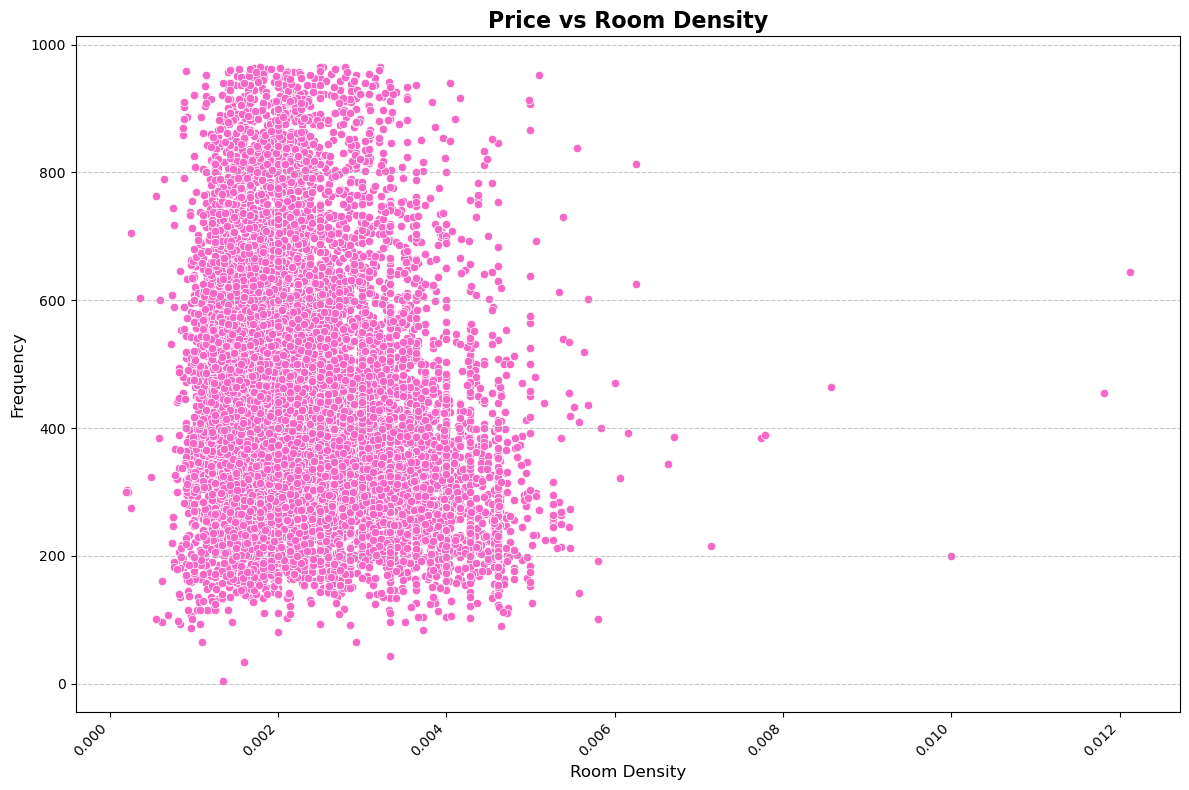

In [20]:
# Identify and visualize key trends
columns_to_plot = [
    col for col in df.columns
    if col not in ['Facilities', 'Price', 'State_code', 'Tenure_code', 'Furnished Type_code', 'Facilities_code', 'House Type_code', 'Facilities_list', 'District']
]
colors = sns.color_palette("husl", n_colors=len(columns_to_plot))

for idx, column in enumerate(columns_to_plot):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x=column, y='Price per sqft', color=colors[idx])
    plt.title(f'Price vs {column}', fontsize=16, fontweight='bold')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [21]:
size_bins = [0, 500, 1000, 1500, 2000, 2500, df['Size'].max()]
size_labels = ['0-500', '501-1000', '1001-1500', '1501-2000', '2001-2500', '2500+']
df['Size_Bins'] = pd.cut(df['Size'], bins=size_bins, labels=size_labels, include_lowest=True)

max_price_per_bedroom = df['Price per Bedroom'].max()
rounded_max_price_per_bedroom = np.ceil(max_price_per_bedroom / 100000) * 100000 
bins_bedroom = np.linspace(0, rounded_max_price_per_bedroom, 6)
labels_bedroom = [f"{int(bins_bedroom[i])}-{int(bins_bedroom[i + 1])}" for i in range(len(bins_bedroom) - 1)]

df['Price_per_Bedroom_Bins'] = pd.cut(df['Price per Bedroom'], bins=bins_bedroom, labels=labels_bedroom, include_lowest=True)

binned_columns = ['Size_Bins', 'Price_per_Bedroom_Bins']
binned_labels = ['Size', 'Price per Bedroom']
binned_colors = colors[-3:]

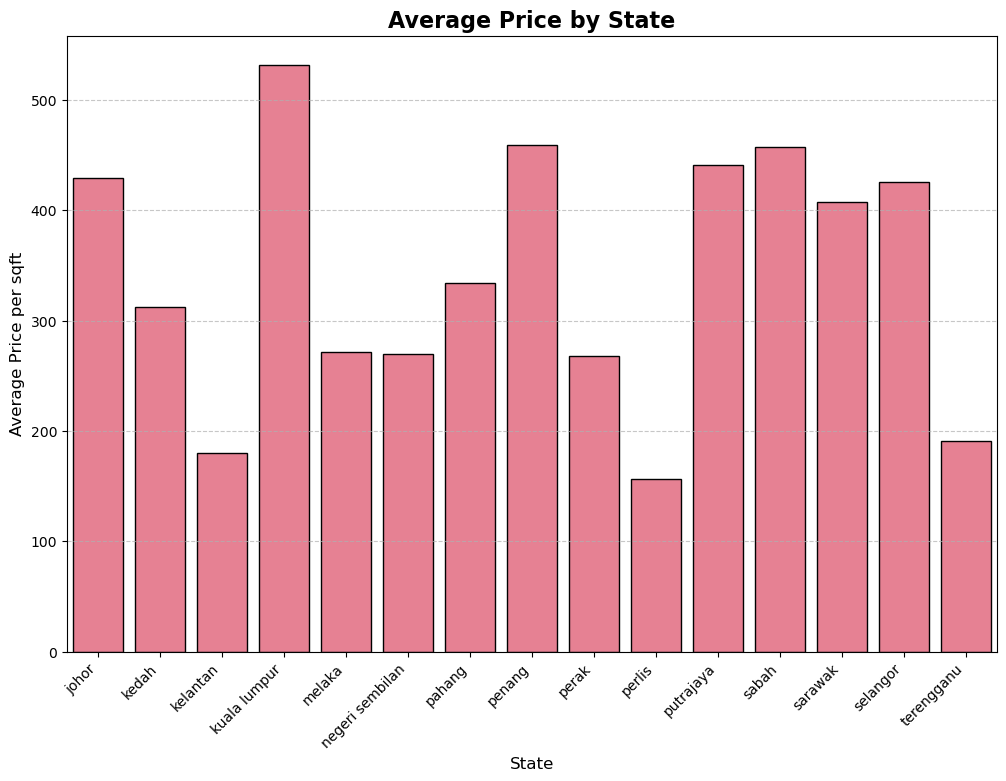

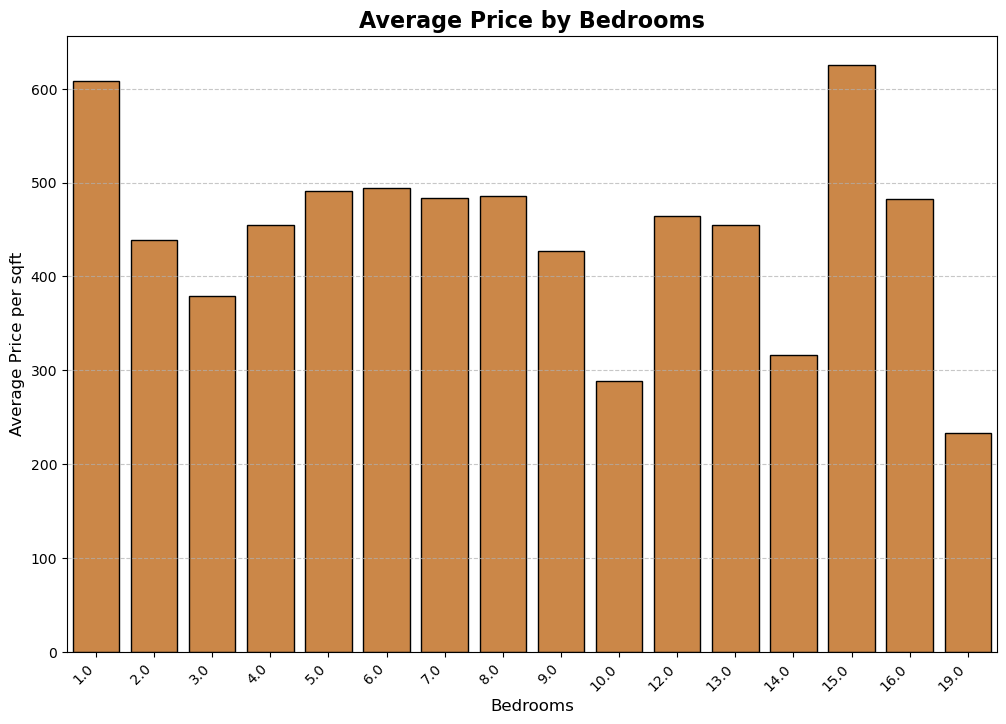

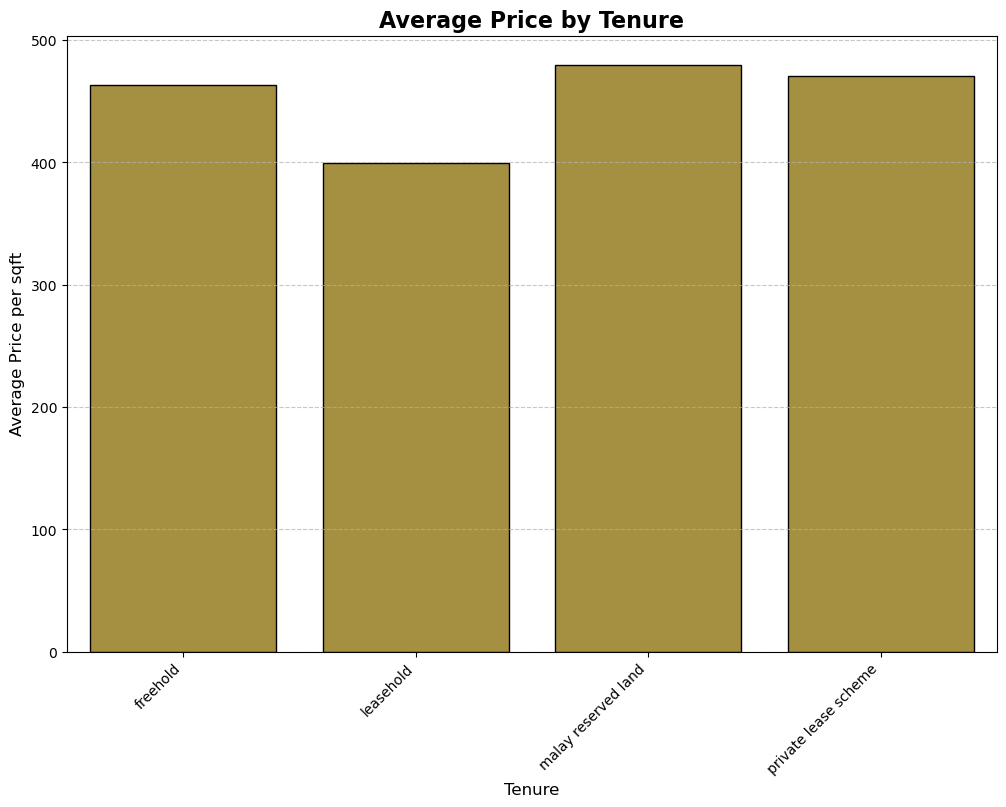

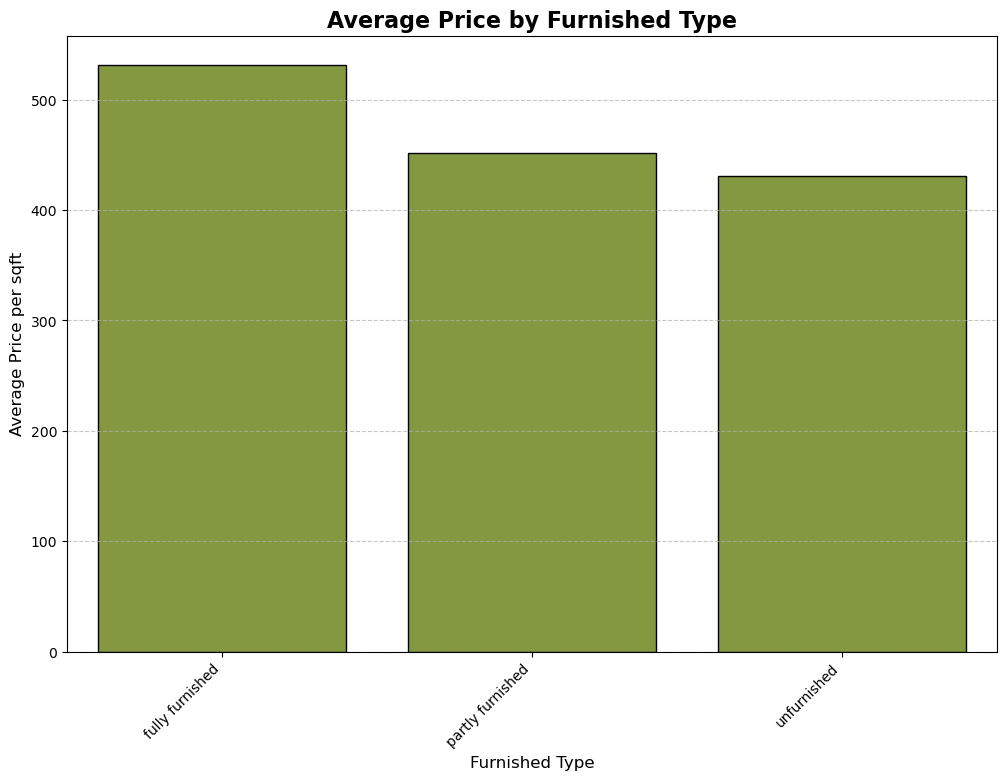

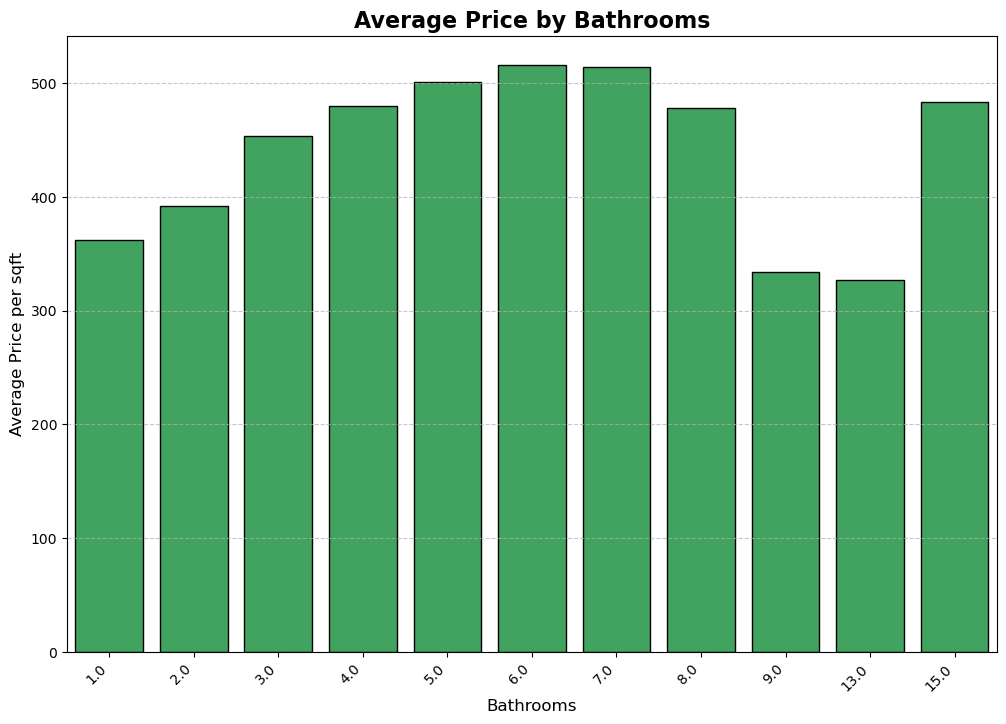

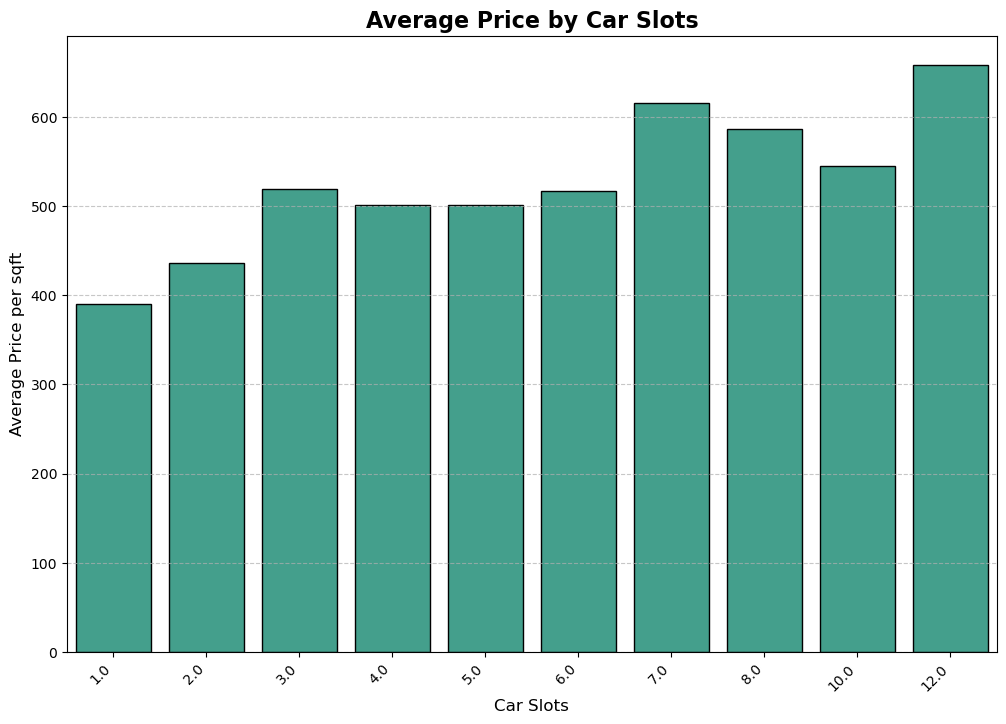

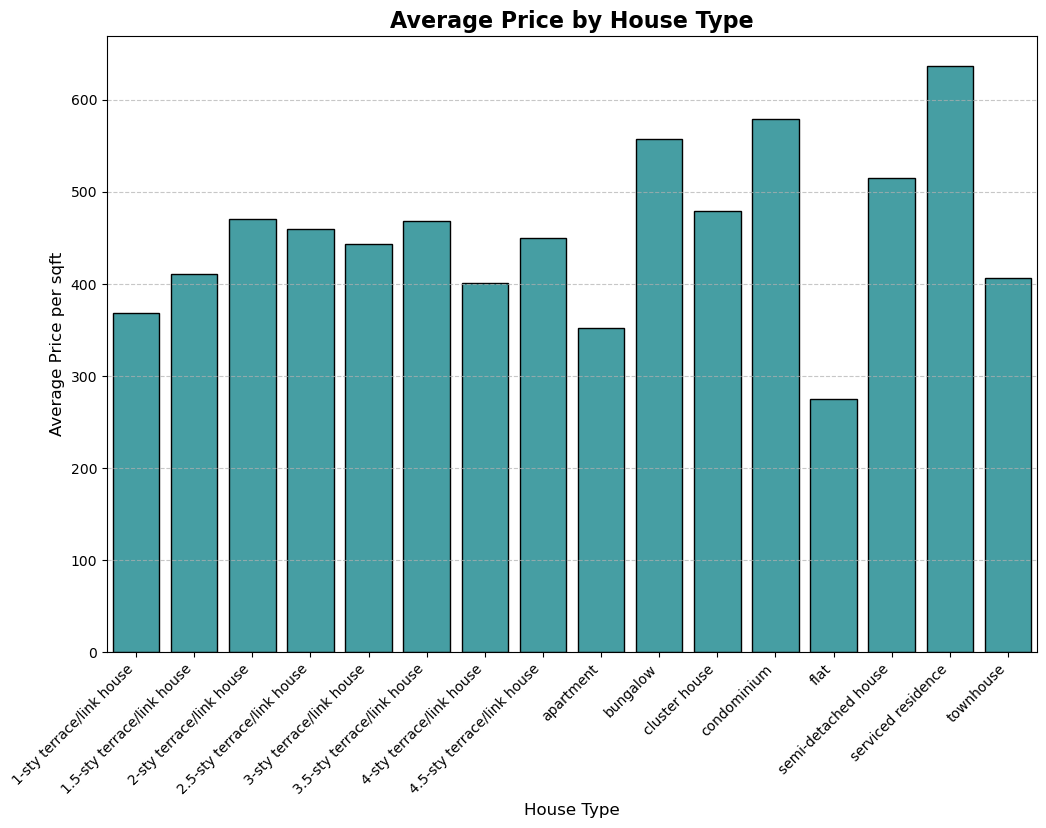

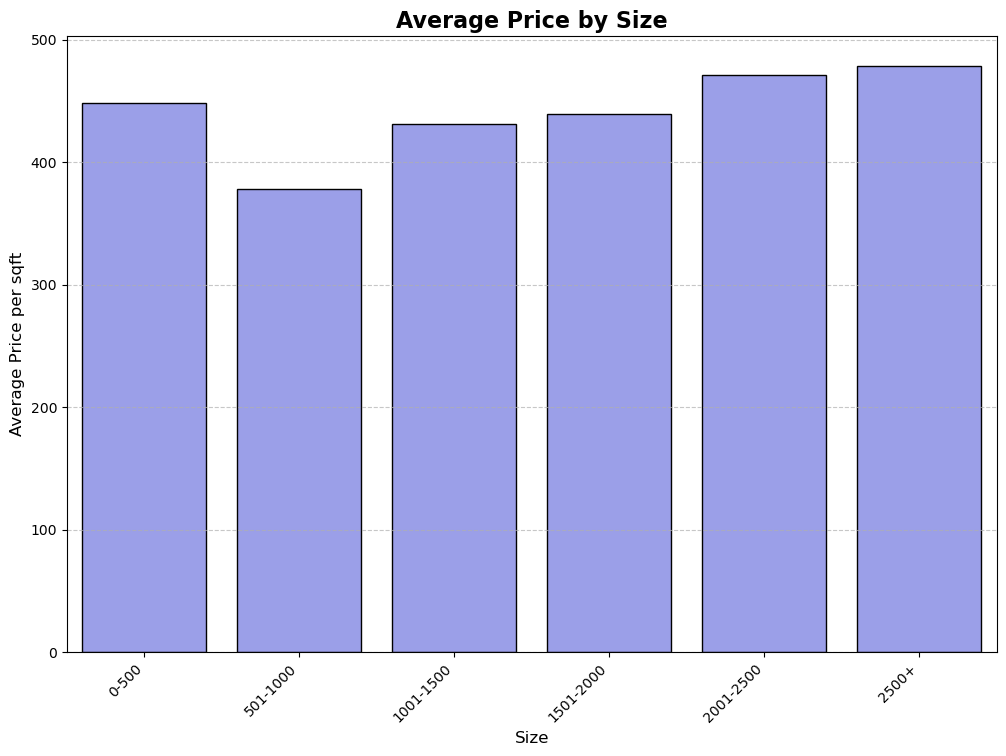

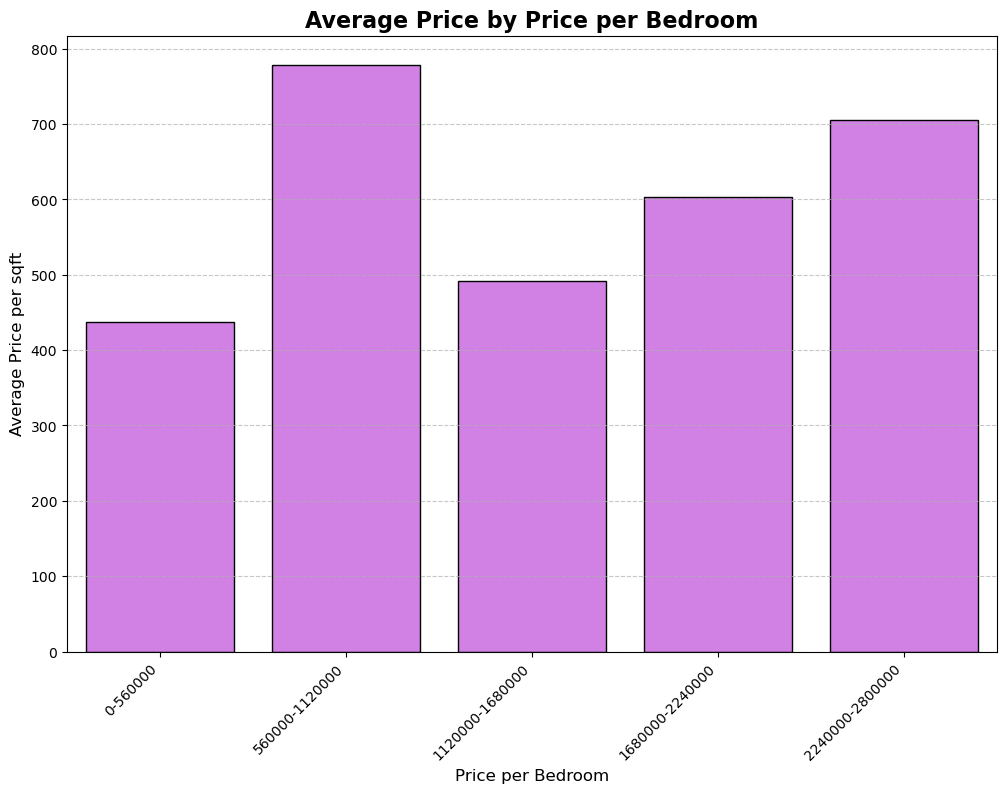

In [22]:
# Bar plotting
columns_to_plot = [
    col for col in df.columns
    if col not in ['Facilities', 'Price', 'State_code', 'Tenure_code', 'Furnished Type_code', 'Facilities_code', 'House Type_code', 'Facilities_list', 'Size', 'Price per sqft', 'Price per Bedroom', 'Room Density', 'Price_per_Bedroom_Bins', 'Size_Bins', 'Price_per_Sqft_Bins', 'District', 'District_code']
]
colors = sns.color_palette("husl", n_colors=len(columns_to_plot)+4)

for idx, column in enumerate(columns_to_plot):
    avg_price = df.groupby(column)['Price per sqft'].mean().reset_index()
    plt.figure(figsize=(12, 8))
    sns.barplot(data=avg_price, x=column, y='Price per sqft', color=colors[idx], edgecolor="black")
    plt.title(f'Average Price by {column}', fontsize=16, fontweight='bold')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Average Price per sqft', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

for idx, binned_column in enumerate(binned_columns):
    avg_price = df.groupby(binned_column, observed=True)['Price per sqft'].mean().reset_index()
    plt.figure(figsize=(12, 8))
    sns.barplot(data=avg_price, x=binned_column, y='Price per sqft', color=binned_colors[idx], edgecolor="black")
    plt.title(f'Average Price by {binned_labels[idx]}', fontsize=16, fontweight='bold')
    plt.xlabel(binned_labels[idx], fontsize=12)
    plt.ylabel('Average Price per sqft', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


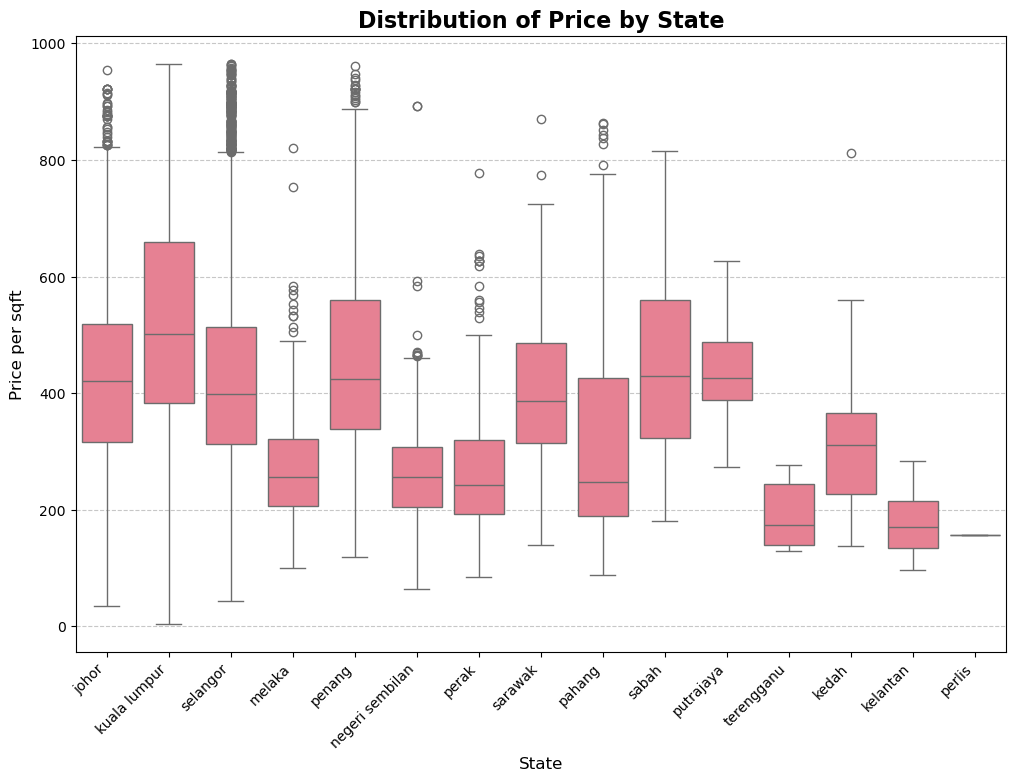

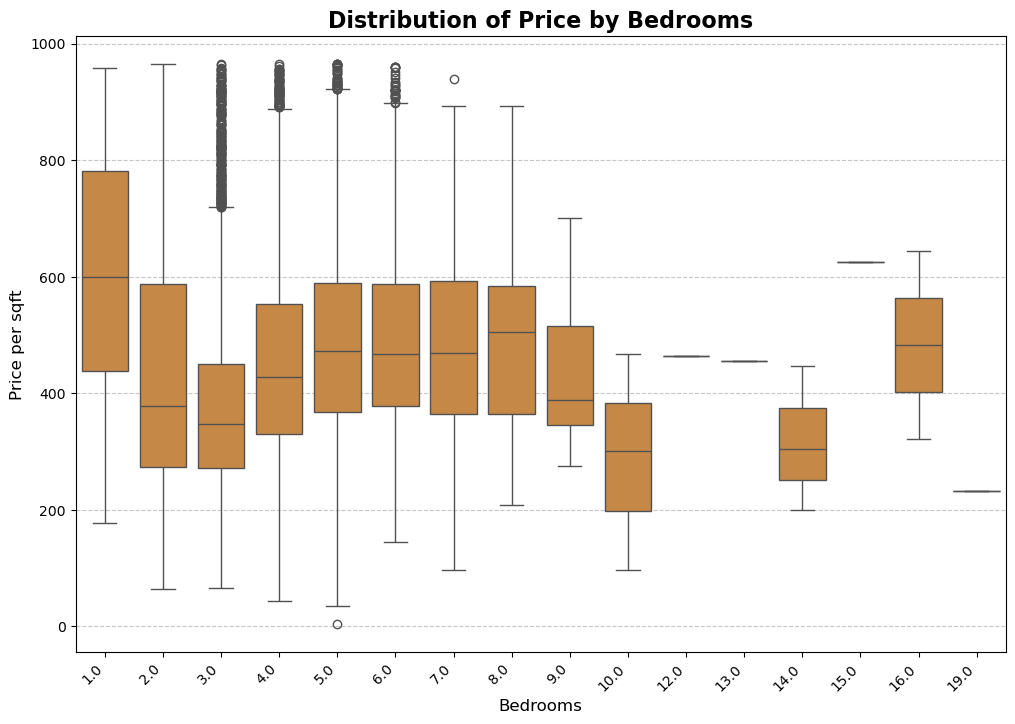

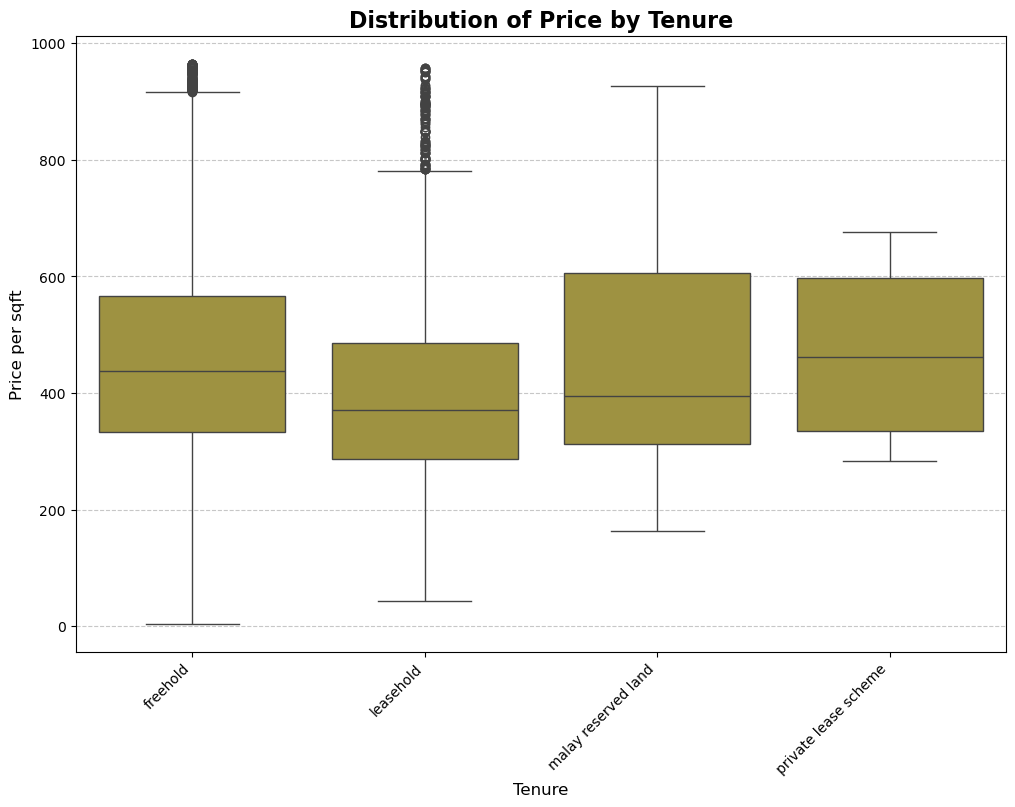

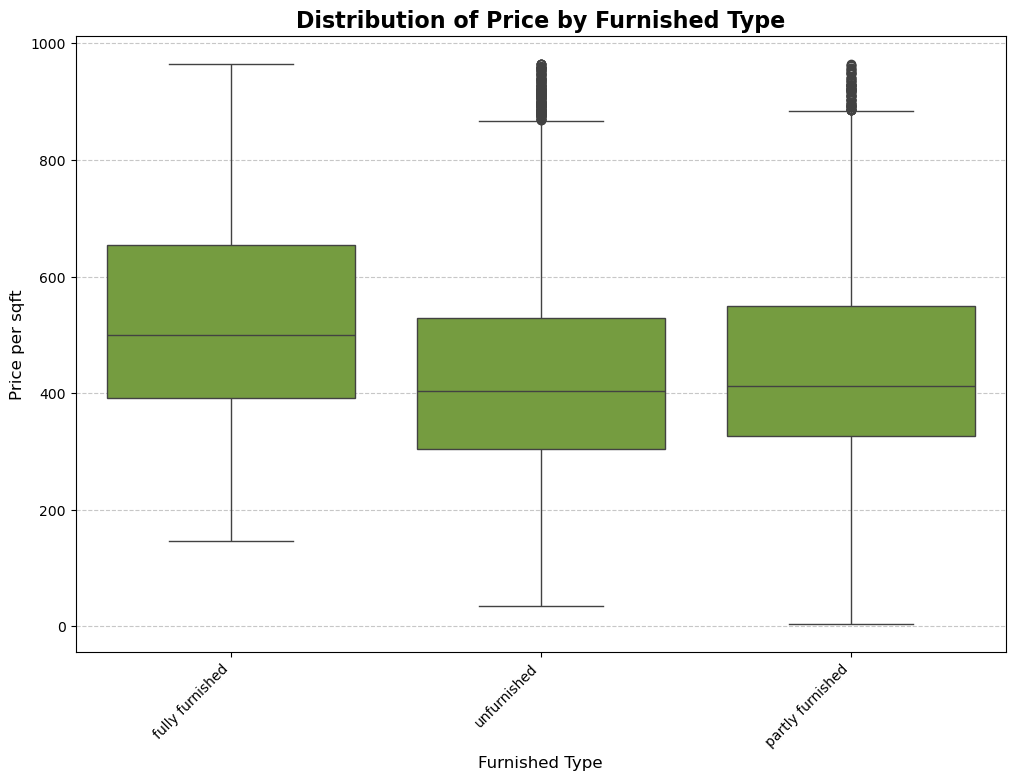

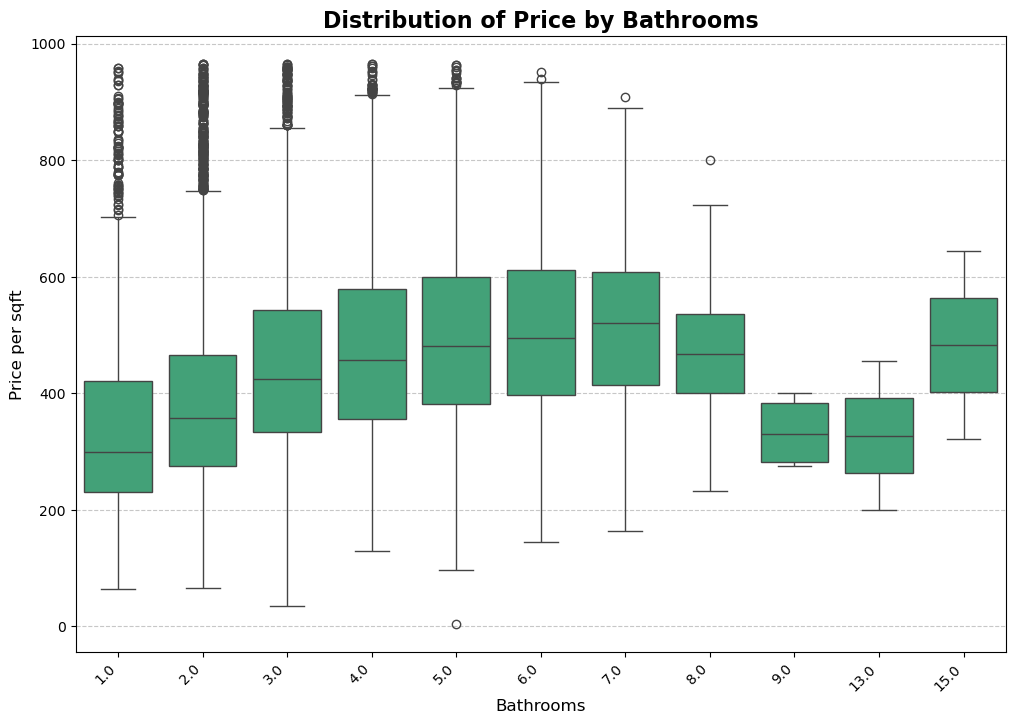

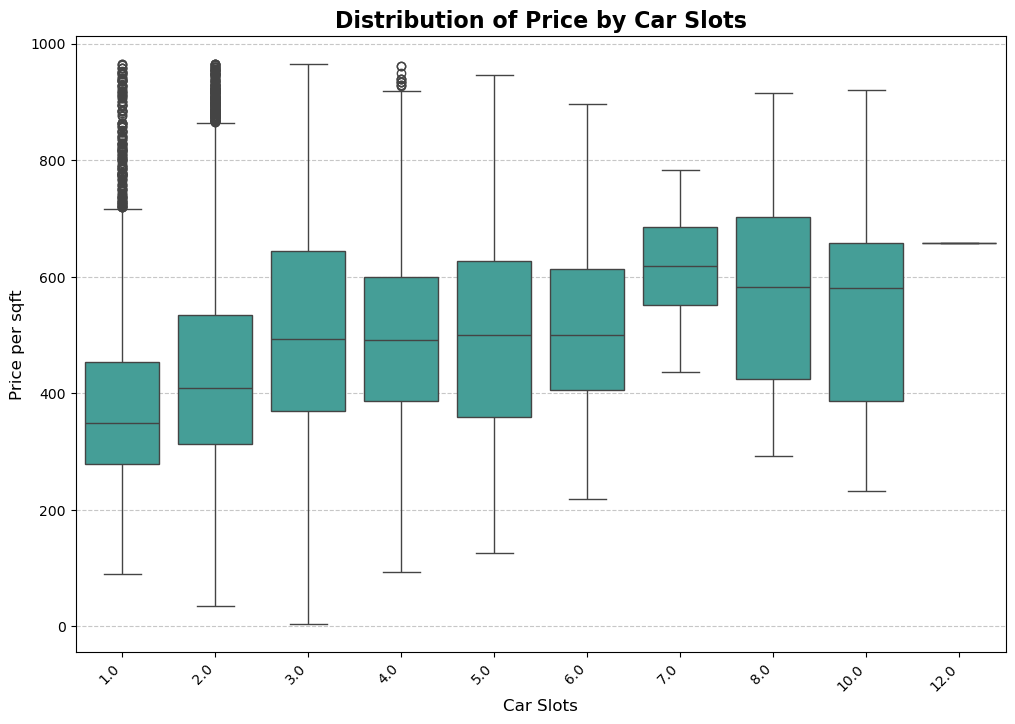

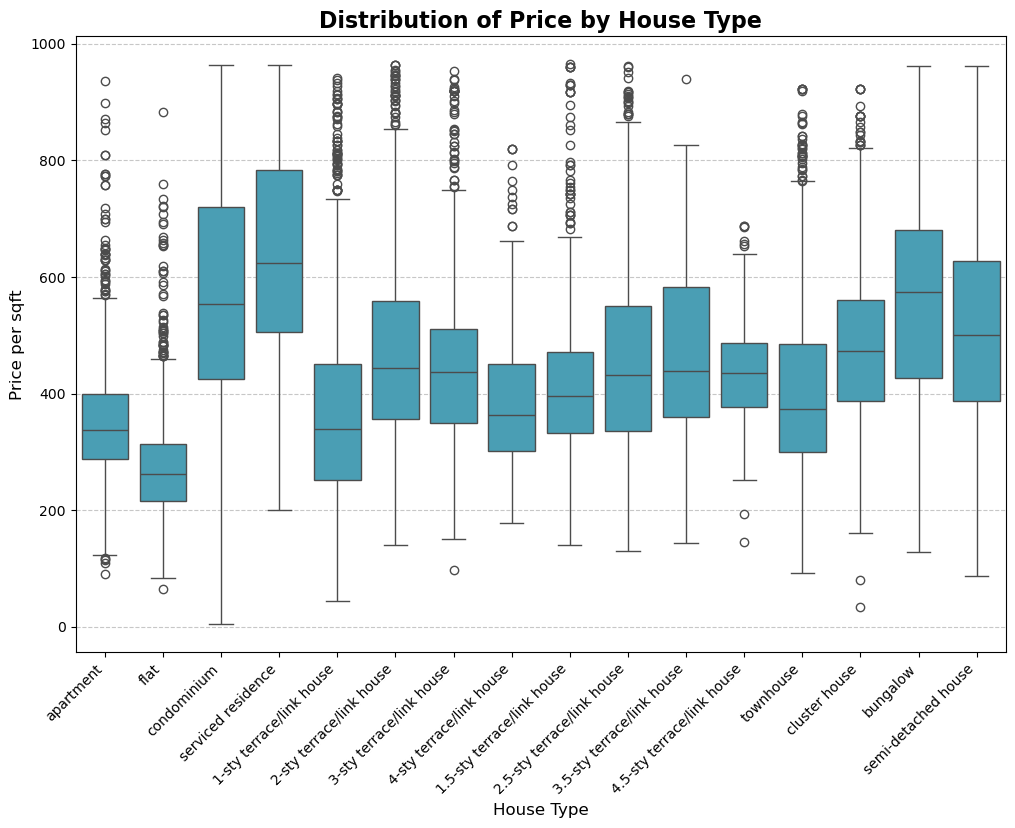

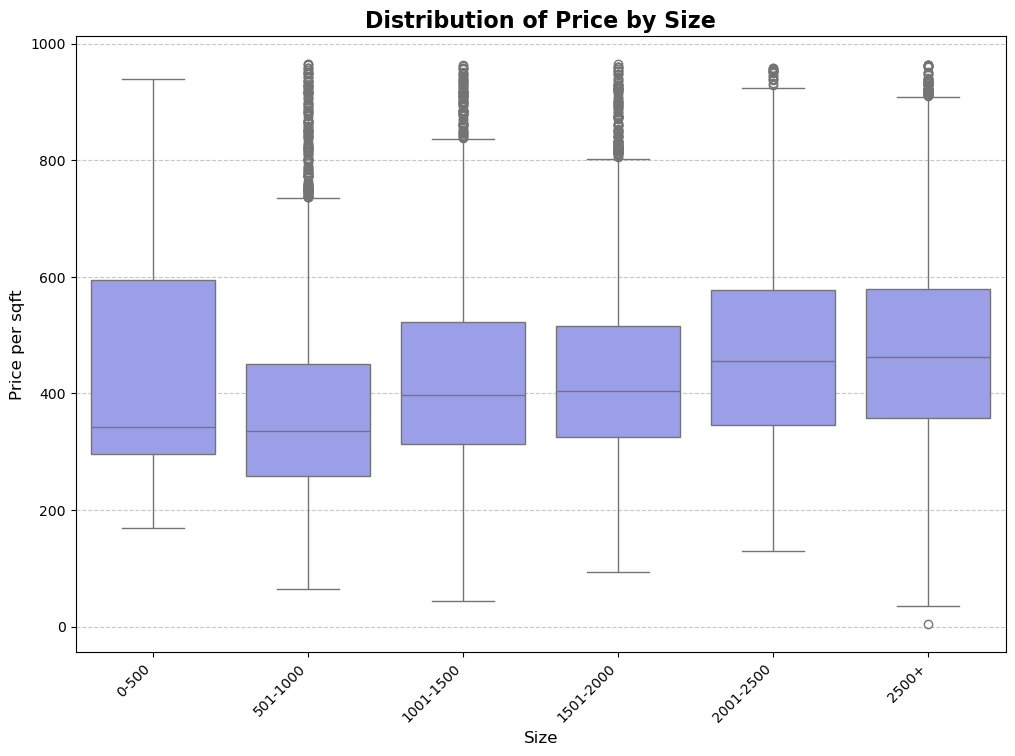

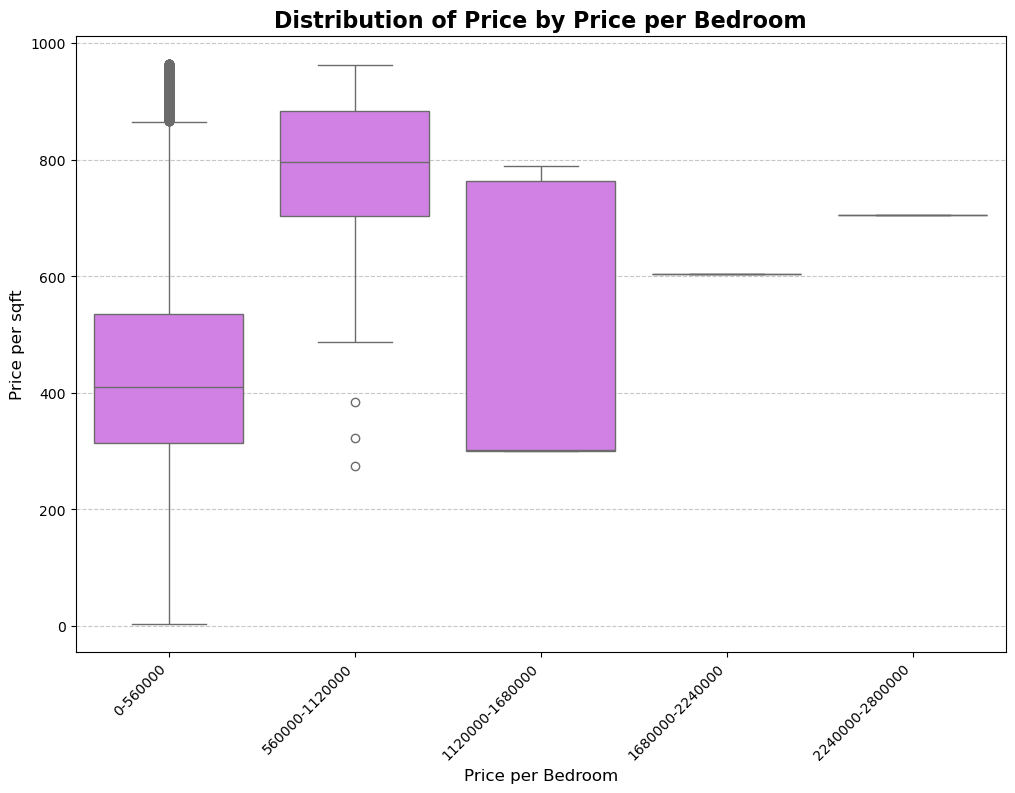

In [23]:
# Box plotting
colors = sns.color_palette("husl", n_colors=len(columns_to_plot)+3)

for idx, column in enumerate(columns_to_plot):
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x=column, y='Price per sqft', color=colors[idx])
    plt.title(f'Distribution of Price by {column}', fontsize=16, fontweight='bold')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Price per sqft', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

for idx, binned_column in enumerate(binned_columns):
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x=binned_column, y='Price per sqft', color=binned_colors[idx])
    plt.title(f'Distribution of Price by {binned_labels[idx]}', fontsize=16, fontweight='bold')
    plt.xlabel(binned_labels[idx], fontsize=12)
    plt.ylabel('Price per sqft', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


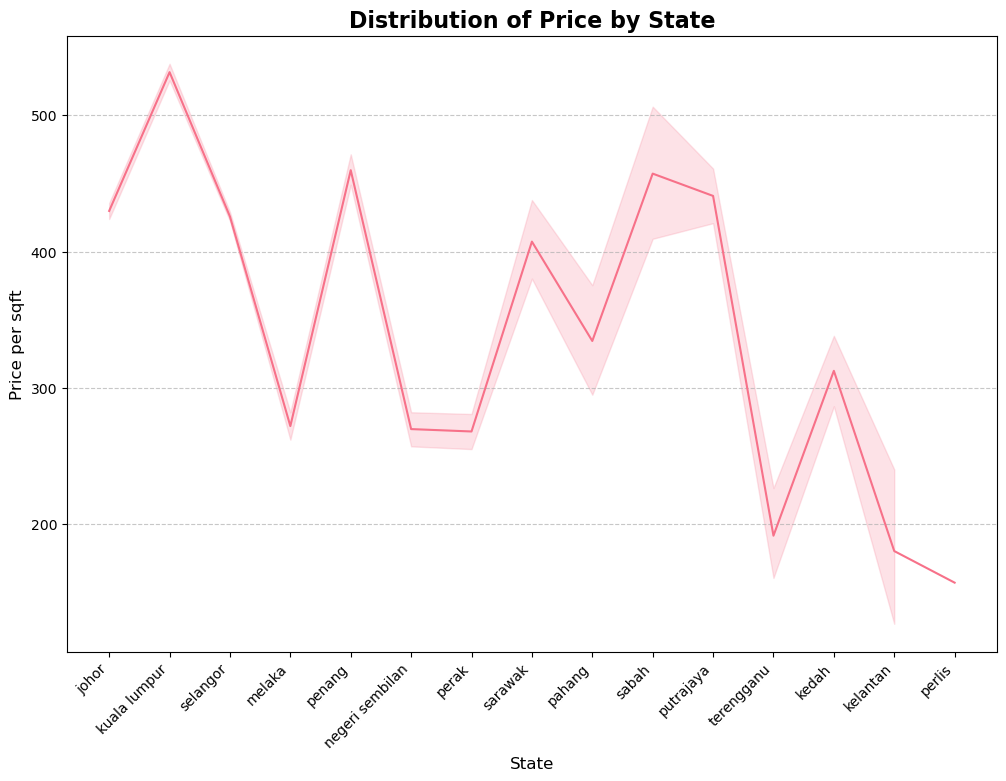

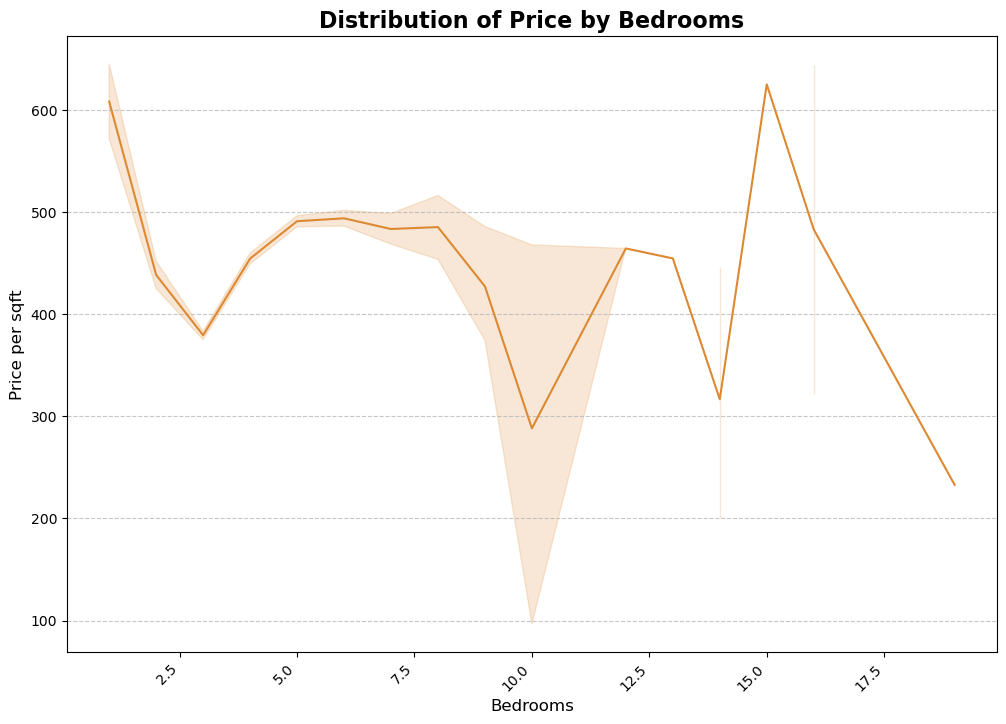

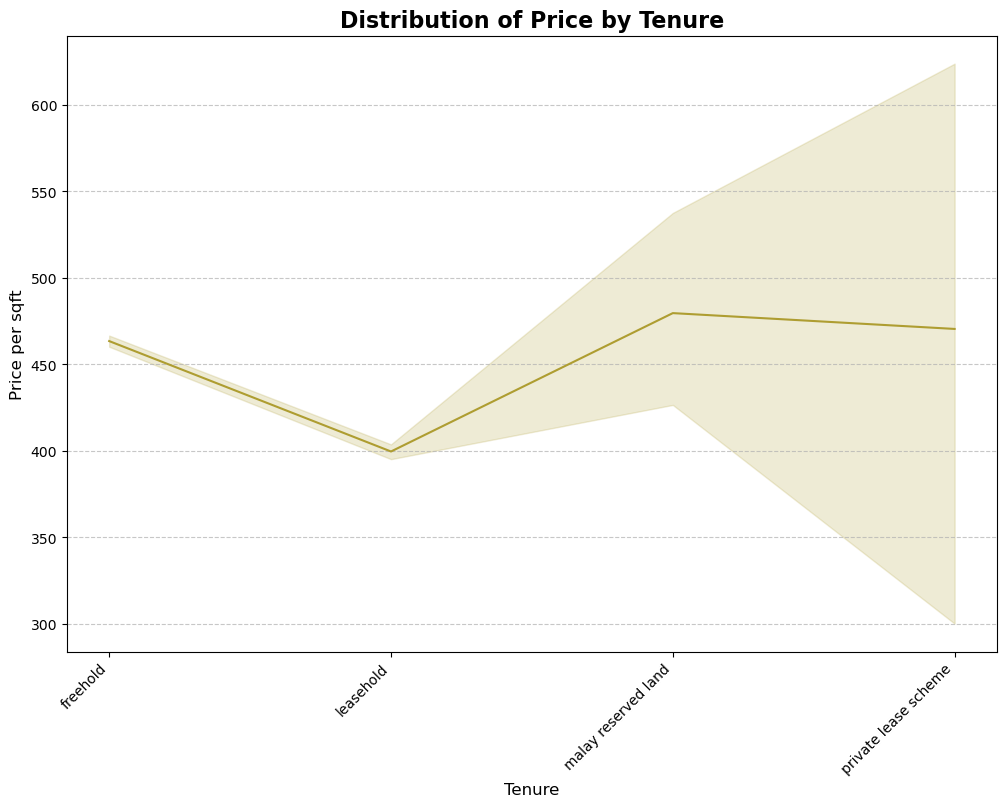

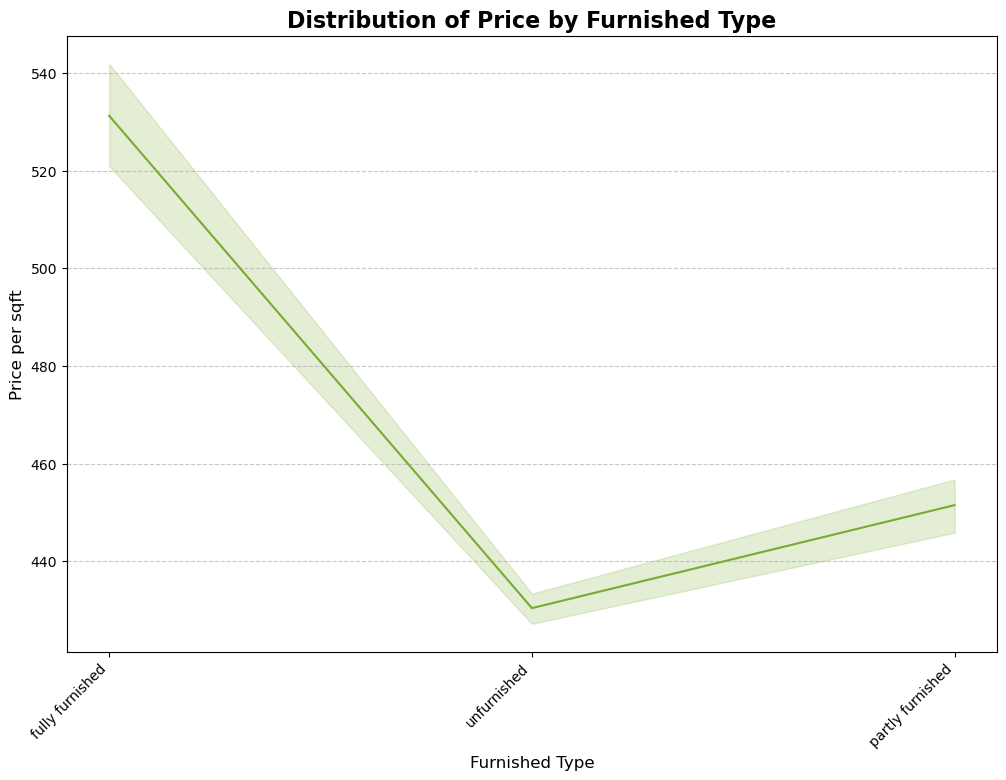

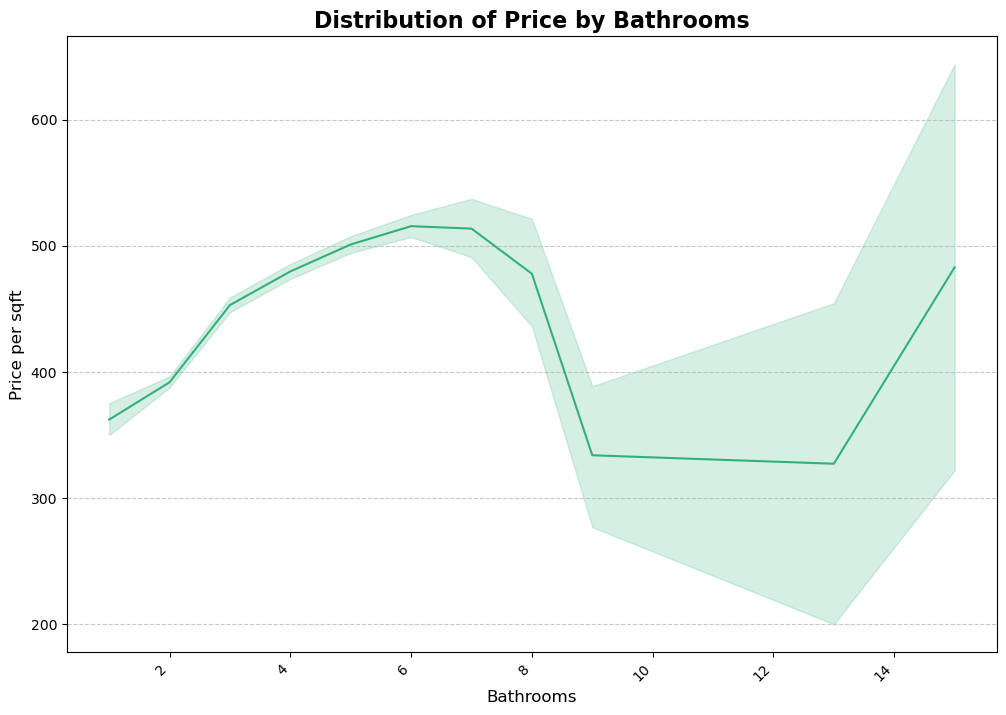

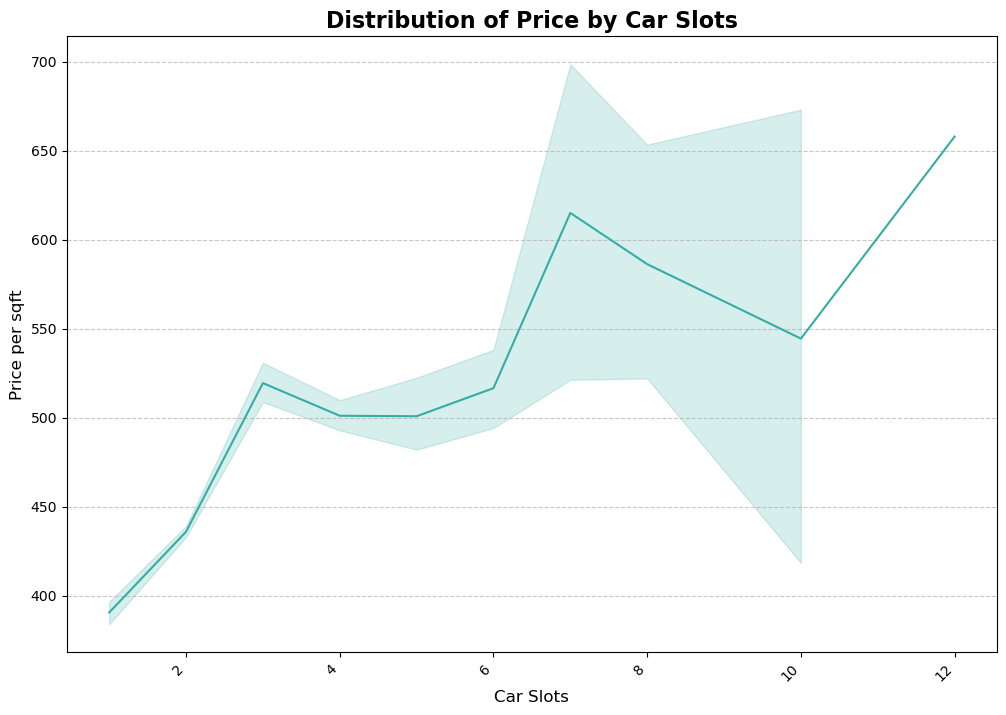

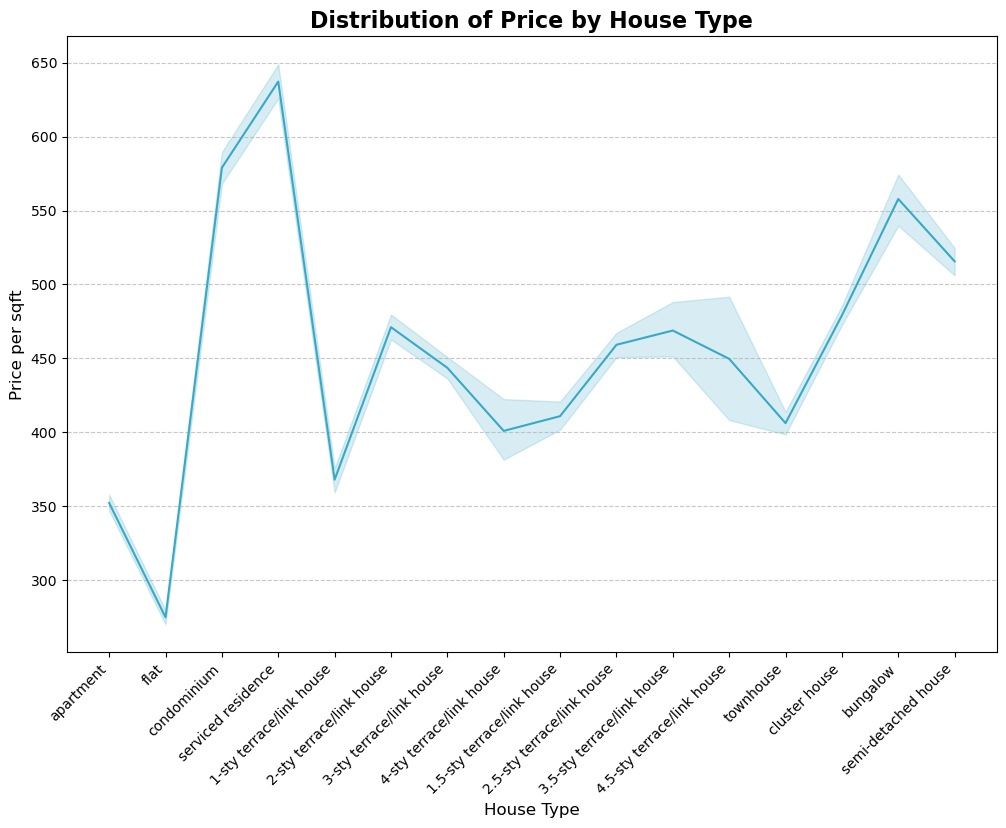

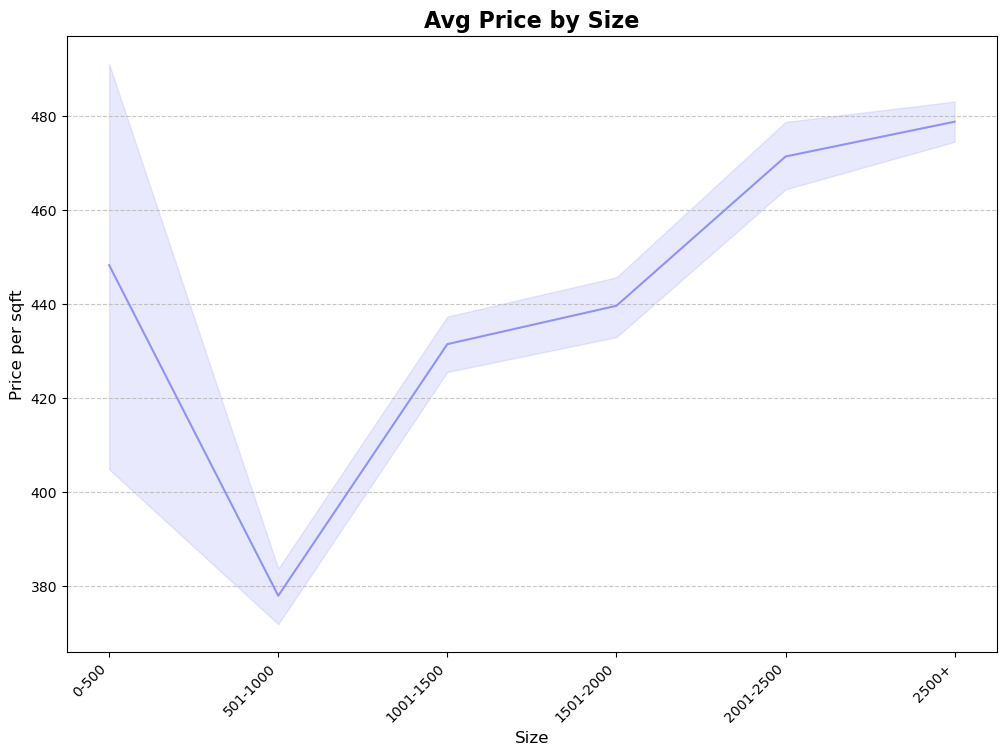

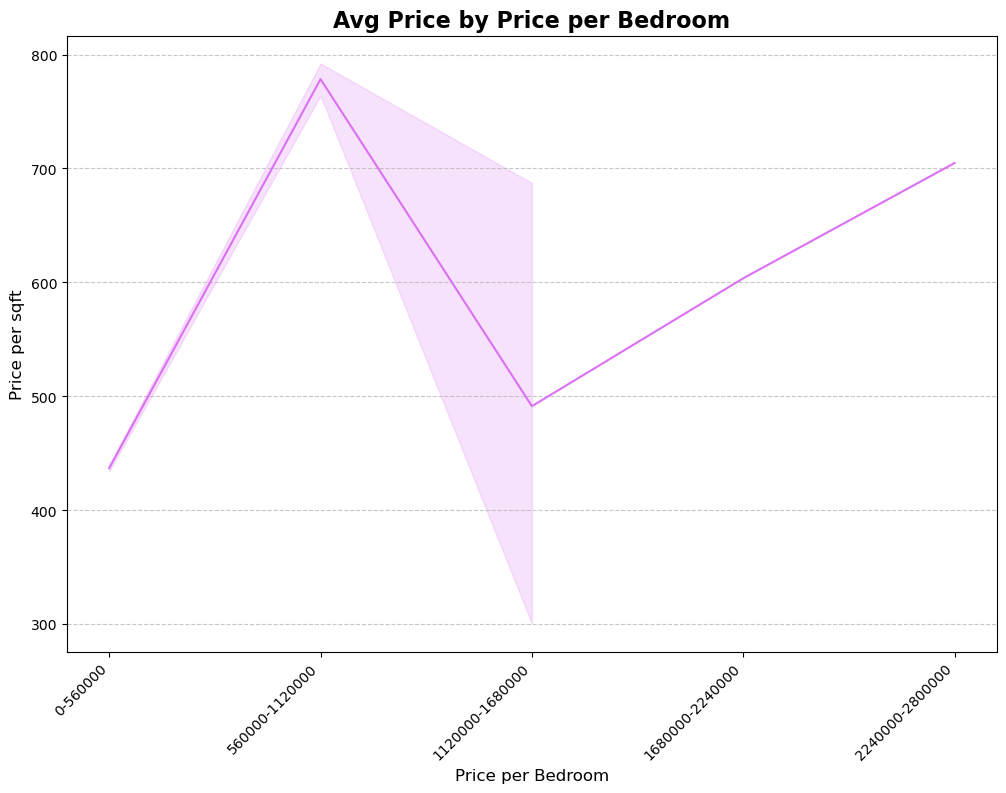

In [24]:
# Line plotting
colors = sns.color_palette("husl", n_colors=len(columns_to_plot)+3)

for idx, column in enumerate(columns_to_plot):
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df, x=column, y='Price per sqft', color=colors[idx])
    plt.title(f'Distribution of Price by {column}', fontsize=16, fontweight='bold')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Price per sqft', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

for idx, binned_column in enumerate(binned_columns):
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df, x=binned_column, y='Price per sqft', color=binned_colors[idx])
    plt.title(f'Avg Price by {binned_labels[idx]}', fontsize=16, fontweight='bold')
    plt.xlabel(binned_labels[idx], fontsize=12)
    plt.ylabel('Price per sqft', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# 🏡 Capstone Project Documentation

## **1. Data Collection and Preprocessing**

### 📥 Data Sources and Collection Methods
- Data collected from **iProperty Malaysia** using web scraping.
- House types scraped include:
  - 🏢 Apartments, Flats, Condominiums
  - 🏘️ Terrace/Link Houses (1-sty, 2-sty, etc.)
  - 🏠 Townhouses, Cluster Houses, Semi-Detached Houses, Bungalows, etc.
- Attributes scraped:
  - `Price`, `Size`, `Bedrooms`, `Bathrooms`, `Location`, `Facilities`, and `House Type`.

---

### 🧹 Data Cleaning Procedures
1. **🔄 Remove Duplicates:** Avoided by maintaining a set of existing records.
2. **📉 Handle Missing Values:**
   - Removed rows missing critical values (`Price`, `Size`).
   - Imputed numerical columns (`Bedrooms`, `Bathrooms`, `Car Slots`) using the median.
3. **🚫 Address Outliers:** Used the IQR method to clip outliers in `Price`, `Size`, and `Price per Sqft`.
4. **🖋️ Fix Inconsistent Formatting:** Cleaned categorical values using `.str.strip()` and `.str.lower()`.

---

### 🛠️ Feature Engineering
1. **🆕 Derived Features:**
   - `Price per Bedroom`: Total price divided by the number of bedrooms.
2. **📊 Binned Features:**
   - **`Size_Bins`:** `0-500`, `501-1000`, ..., `2500+`.
   - **`Price_per_Sqft_Bins`:** `0-200`, `201-400`, ..., `1K+`.
   - **`Price_per_Bedroom_Bins`:** `0-50K`, `51-100K`, ..., `250K+`.

---

### ✅ Data Quality Validation
- **Summary Statistics:** Used `df.describe()` for quality checks.
- **Missing Values:** Addressed and validated.

---

### 📄 Documentation of Preprocessing Steps
- Code implemented the above cleaning and preprocessing steps systematically.

---

## **2. Exploratory Data Analysis**

### 📊 Summary Statistics
- Generated metrics for numerical columns:
  - **Mean:** `Price`: RM 1.6M.
  - **Median:** `Bedrooms`: 4.
  - **Range:** `Price`: RM 92K to RM 4.4M.

---

### 📈 Distribution Analysis
- Created **Histograms** and **KDE plots**:
  - `Price` is right-skewed; most properties are under RM 2M.
  - `Size` clusters between 1,000–3,000 sq. ft.

---

### 🔗 Correlation Analysis
- **Heatmap** findings:
  - `Price` and `Size` are strongly correlated (+0.8).
  - Moderate correlation between `Price per Sqft` and `Bedrooms`.

---

### 🔍 Key Trends
- **Scatterplots:**
  - Larger properties generally have higher prices.
  - More bedrooms correlate with higher prices.

---

### 📑 Segmentation
- **Size Bins:** Most properties are `1001-1500` sq. ft.
- **Price per Bedroom Bins:** Majority fall in the `51K-100K` range.

---

### 📊 Visualizations
1. **📊 Bar Plots:** Average price by `State`, `Tenure`, and more.
2. **📈 Scatterplots:** Price trends against numerical variables.
3. **📦 Box Plots:** Distribution of prices by `Size_Bins` and `Price_per_Sqft_Bins`.
4. **📊 Histograms:** Distributions of `Price`, `Size`, and other variables.
5. **🌡️ Heatmaps:** Correlation matrix.

---

### 📝 Key Findings
- **Larger properties = Higher prices.**
- **Freehold properties dominate listings.**
- **Price per square foot** varies significantly by state and property type.

---

### 🔮 Potential Areas for Deeper Investigation
1. **📍 Price Variations by Location:** Compare districts within states.
2. **🏊 Impact of Facilities:** Explore how facilities affect pricing.
3. **📊 Market Segmentation:** Examine trends in high-demand categories like condominiums or terrace houses.

---

## 📝 Notes

- **🎯 Objective:** The primary goal of this project is to analyze property pricing trends in Malaysia and identify key factors that influence property value.
- **🌍 Data Scope:** 
  - The dataset was scraped from **iProperty Malaysia**.
  - It includes various house types such as 🏢 apartments, 🏠 terrace houses, and 🏡 bungalows.
- **⚠️ Limitations:**
  - The dataset may not fully represent all property listings in Malaysia.
  - Missing values for certain columns were imputed, which could introduce bias.
  - The analysis assumes the scraped data is accurate and up-to-date.
- **🛠️ Tools Used:**
  - Python libraries such as:
    - **🐍 Selenium** for web scraping.
    - **📊 Pandas** for data cleaning and manipulation.
    - **📈 Seaborn & Matplotlib** for visualization.
- **🔮 Future Steps:**
  - Collect more recent data to expand the analysis over time.
  - Include 🏘️ rental properties in the dataset for rental trend analysis.
  - Apply **🤖 machine learning models** to predict property prices based on key features.

---

### **Legend**
- **📥** Data collection
- **🧹** Cleaning
- **📊** Visuals
- **🔍** Trends
- **🔗** Correlation
- **📝** Findings
- **🔮** Deeper investigation


In [25]:
# Display all columns without truncation
pd.set_option('display.max_columns', None)


# Display all rows without truncation
pd.set_option('display.max_rows', None)

# Reset back to default (optional)

# pd.reset_option('display.max_columns')
# pd.reset_option('display.max_rows')

In [26]:
df = pd.read_csv('data/cleaned_combined_property_data.csv')

In [27]:
label_encoders = {}
for column in df.columns:
    if df[column].dtype == 'object' and column != 'Facilities':
        label_encoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column])
        label_encoders[column] = label_encoder

In [28]:
for column, encoder in label_encoders.items():
    print(f"Column: {column}")
    print(f"Mapping: {dict(enumerate(encoder.classes_))}")

Column: District
Mapping: {0: 'alai', 1: 'alor gajah', 2: 'alor setar', 3: 'ampang', 4: 'ara damansara', 5: 'ayer hitam', 6: 'ayer itam', 7: 'ayer keroh', 8: 'ayer molek', 9: 'bachang', 10: 'bachok', 11: 'bagan serai', 12: 'bahau', 13: 'balai panjang', 14: 'balakong', 15: 'balik pulau', 16: 'bandar darulaman', 17: 'bandar enstek', 18: 'bandar kinrara', 19: 'bandar menjalara', 20: 'bandar sri damansara', 21: 'bandar sri sendayan', 22: 'bandar sungai long', 23: 'bandar tasik selatan', 24: 'bandar utama', 25: 'banggul', 26: 'bangi', 27: 'bangsar', 28: 'banting', 29: 'batang berjuntai', 30: 'batu arang', 31: 'batu berendam', 32: 'batu caves', 33: 'batu feringghi', 34: 'batu gajah', 35: 'batu kawan', 36: 'batu maung', 37: 'batu pahat', 38: 'bayan baru', 39: 'bayan lepas', 40: 'bedong', 41: 'bekenu', 42: 'bemban', 43: 'bentong', 44: 'beranang', 45: 'bertam', 46: 'beserah', 47: 'bidor', 48: 'bota', 49: 'brickfields', 50: 'bukit baru', 51: 'bukit jalil', 52: 'bukit jambul', 53: 'bukit katil', 

In [29]:
df['Facilities'] = df['Facilities'].apply(lambda x: literal_eval(x) if pd.notna(x) else [])
mlb = MultiLabelBinarizer()
facilities_encoded = mlb.fit_transform(df['Facilities'])
facilities_df = pd.DataFrame(facilities_encoded, columns=mlb.classes_)

In [30]:
df = df.drop(columns=['Facilities']).reset_index(drop=True)
df = pd.concat([df, facilities_df], axis=1)
df.head()

Unnamed: 0   Price  District  State  Bedrooms  Tenure  Furnished Type  \
0           0  680000       280      0       4.0       0               0   
1           1  218000       187      0       3.0       0               2   
2           2  258000        95      3       3.0       0               1   
3           3  290000       189     13       3.0       1               1   
4           4  350000       103      0       3.0       1               2   

     Size  Bathrooms  Car Slots  House Type  Price per sqft  \
0  1317.0        3.0        2.0           8          516.32   
1   750.0        2.0        1.0           8          290.67   
2   905.0        2.0        1.0           8          285.08   
3   775.0        2.0        1.0           8          374.19   
4  1078.0        2.0        2.0           8          324.68   

   Price per Bedroom  Room Density  24-Hour Security  Air Conditioner  \
0      170000.000000      0.003037                 1                1   
1       72666.666667      0.004000                 0                0   
2       86000.000000      0.003315                 1                1   
3       96666.666667      0.003871                 1                0   
4      116666.666667      0.002783                 1                0   

   Badminton Court  Balcony  Basketball Court  Bath Tub  Bbq  Bus Stop  \
0                0        1                 0         0    1         0   
1                0        0                 0         0    0         0   
2                0        0                 0         0    0         0   
3                1        0                 1         0    1         0   
4                0        1                 0         0    1         0   

   Business Centre  Cafe  Clubhouse  Garage  Garden  Gym  Jacuzzi  \
0                0     0          0       0       0    1        0   
1                0     0          0       0       0    0        0   
2                0     0          0       0       0    1        0   
3                0     1          0       0       0    1        0   
4                0     1          0       0       0    0        0   

   Jogging Track  Kitchen Cabinet  Nursery  Parking  Playground  \
0              1                1        0        1           1   
1              0                0        0        0           0   
2              0                1        0        1           1   
3              1                0        1        0           1   
4              1                0        1        0           1   

   Retail Stores  Salon  Sauna  Squash Court  Swimming Pool  Tennis Courts  \
0              0      0      0             0              1              1   
1              0      0      0             0              0              0   
2              1      0      0             0              0              0   
3              1      0      0             0              1              0   
4              1      0      0             0              1              1   

   Wading Pool  
0            0  
1            0  
2            0  
3            0  
4            0

In [31]:
X = df[df.columns.difference(['Unnamed: 0', 'Price per Bedroom', 'Room Density', 'Price', 'Price per sqft', 'Size', 'State'])]

In [32]:
y = df['Price per sqft']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=12)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]  
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2',
    error_score='raise'  
)

grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_

y_pred = model.predict(X_test)

# Calculate all metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print("Best Parameters:", grid_search.best_params_)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")

C:\Users\Logan Kannan\.anaconda\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Mean Squared Error: 12598.996871330675
Mean Absolute Error: 80.94865966742712
R-squared Score: 0.5956342802611385


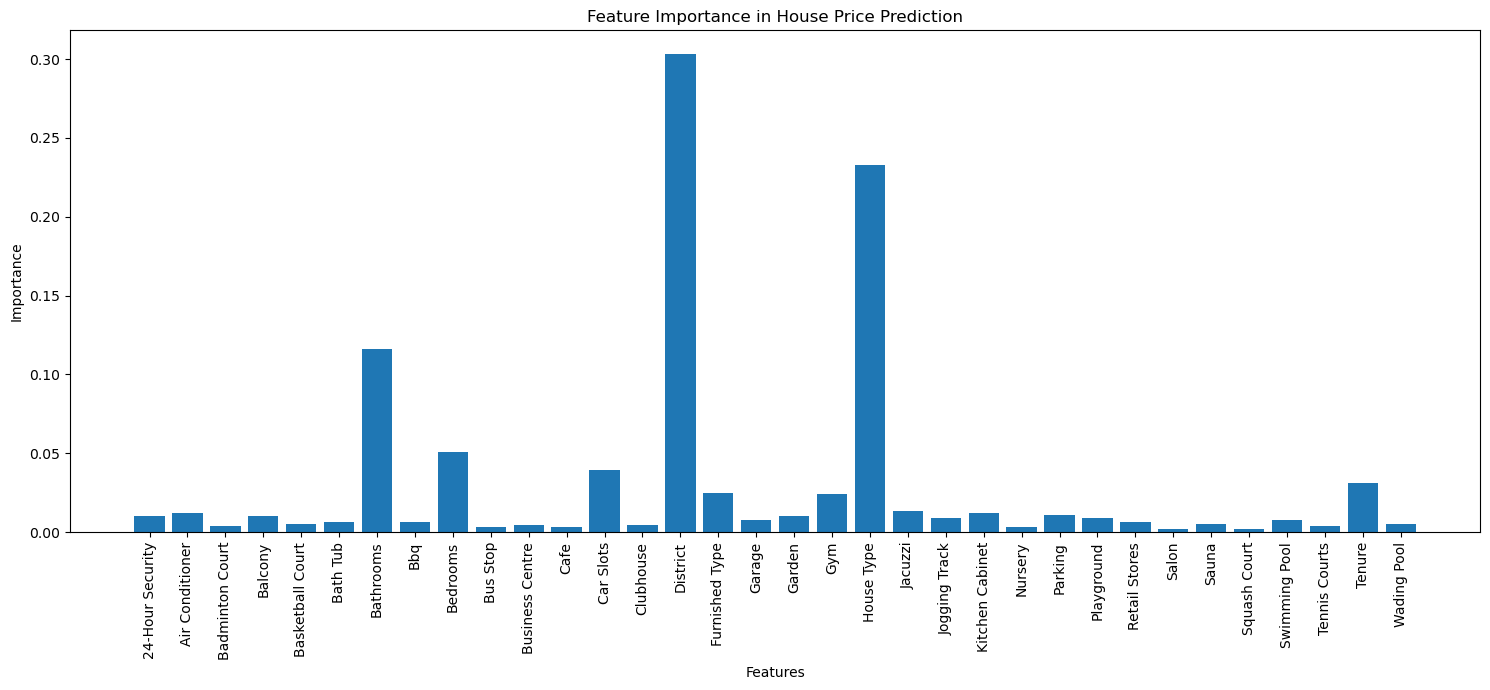

District: 30.31%
House Type: 23.30%
Bathrooms: 11.62%
Bedrooms: 5.09%
Car Slots: 3.92%


In [37]:
feature_importance = model.feature_importances_

plt.figure(figsize=(15, 7))
plt.bar(X.columns, feature_importance)
plt.title('Feature Importance in House Price Prediction')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

top_features = sorted(zip(X.columns, feature_importance), key=lambda x: x[1], reverse=True)[:5]
for feature, importance in top_features:
    print(f"{feature}: {importance * 100:.2f}%")

In [38]:
joblib.dump(model, 'house_price_model.pkl')
joblib.dump(scaler, 'scaler_price_scaler.pkl')

['scaler_price_scaler.pkl']